In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpyy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(1024,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


Using TensorFlow backend.


10634049

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [2]:
PATH = "/home/ubuntu/keras-oneshot" #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "train.pickle"),"rb") as f:
    (X,c) = pickle.load(f,encoding='bytes')

with open(os.path.join(PATH, "val.pickle"),"rb") as f:
    (Xval,cval) = pickle.load(f,encoding='bytes')
    
print("training alphabets")
print(c.keys())
print("validation alphabets:")
print(cval.keys())

training alphabets
dict_keys([b'Alphabet_of_the_Magi', b'Cyrillic', b'Gujarati', b'Japanese_(katakana)', b'Japanese_(hiragana)', b'Sanskrit', b'Korean', b'Mkhedruli_(Georgian)', b'Ojibwe_(Canadian_Aboriginal_Syllabics)', b'Latin', b'Early_Aramaic', b'Grantha', b'Asomtavruli_(Georgian)', b'Burmese_(Myanmar)', b'Bengali', b'Inuktitut_(Canadian_Aboriginal_Syllabics)', b'Armenian', b'Anglo-Saxon_Futhorc', b'Tifinagh', b'Balinese', b'Braille', b'Greek', b'Tagalog', b'N_Ko', b'Blackfoot_(Canadian_Aboriginal_Syllabics)', b'Arcadian', b'Malay_(Jawi_-_Arabic)', b'Futurama', b'Hebrew', b'Syriac_(Estrangelo)'])
validation alphabets:
dict_keys([b'Atemayar_Qelisayer', b'ULOG', b'Sylheti', b'Angelic', b'Glagolitic', b'Aurek-Besh', b'Oriya', b'Ge_ez', b'Avesta', b'Kannada', b'Tengwar', b'Keble', b'Mongolian', b'Gurmukhi', b'Manipuri', b'Malayalam', b'Atlantean', b'Old_Church_Slavonic_(Cyrillic)', b'Tibetan', b'Syriac_(Serto)'])


In [3]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f,encoding='bytes')
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            (low, high) = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),
                            
                             )
    
    
#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from /home/ubuntu/keras-oneshot/train.pickle
loading data from /home/ubuntu/keras-oneshot/val.pickle


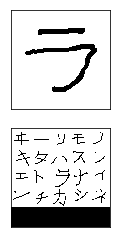

In [4]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train",b'Japanese_(katakana)')
plot_oneshot_task(pairs)


In [ ]:

#Training loop
print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=1 # interval for printing loss (iterations)
batch_size = 32
n_iter = 30000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 #how mahy one-shot tasks to validate on?
best = 9999
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))


!
training
2.63734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 15.2% 20 way one-shot learning accuracy
iteration 1, training loss: 2.64,
2.62613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 20.8% 20 way one-shot learning accuracy
iteration 2, training loss: 2.63,
2.60396
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.6% 20 way one-shot learning accuracy
iteration 3, training loss: 2.60,
2.58433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.0% 20 way one-shot learning accuracy
iteration 4, training loss: 2.58,
2.56434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.0% 20 way one-shot learning accuracy
iteration 5, training loss: 2.56,
2.55854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 2

Got an average of 15.6% 20 way one-shot learning accuracy
iteration 47, training loss: 2.22,
2.14766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 25.6% 20 way one-shot learning accuracy
iteration 48, training loss: 2.15,
2.12614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.4% 20 way one-shot learning accuracy
iteration 49, training loss: 2.13,
2.13202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 19.6% 20 way one-shot learning accuracy
iteration 50, training loss: 2.13,
2.02208
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 15.2% 20 way one-shot learning accuracy
iteration 51, training loss: 2.02,
2.06434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 16.4% 20 way one-shot learning accuracy
iteration 52, training loss: 2.06,
2.08257
evaluatin

Got an average of 22.4% 20 way one-shot learning accuracy
iteration 94, training loss: 1.79,
1.79758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 24.4% 20 way one-shot learning accuracy
iteration 95, training loss: 1.80,
1.87229
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.4% 20 way one-shot learning accuracy
iteration 96, training loss: 1.87,
1.86258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 22.4% 20 way one-shot learning accuracy
iteration 97, training loss: 1.86,
1.80037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 13.6% 20 way one-shot learning accuracy
iteration 98, training loss: 1.80,
1.91569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 18.0% 20 way one-shot learning accuracy
iteration 99, training loss: 1.92,
1.78209
evaluatin

Got an average of 20.0% 20 way one-shot learning accuracy
iteration 140, training loss: 1.72,
1.63606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 16.4% 20 way one-shot learning accuracy
iteration 141, training loss: 1.64,
1.72394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 22.8% 20 way one-shot learning accuracy
iteration 142, training loss: 1.72,
1.81086
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 14.8% 20 way one-shot learning accuracy
iteration 143, training loss: 1.81,
1.65768
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 16.0% 20 way one-shot learning accuracy
iteration 144, training loss: 1.66,
1.57186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 20.4% 20 way one-shot learning accuracy
iteration 145, training loss: 1.57,
1.56084
eva

Got an average of 21.2% 20 way one-shot learning accuracy
iteration 186, training loss: 1.48,
1.51571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 19.6% 20 way one-shot learning accuracy
iteration 187, training loss: 1.52,
1.5544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 22.8% 20 way one-shot learning accuracy
iteration 188, training loss: 1.55,
1.55141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 27.2% 20 way one-shot learning accuracy
iteration 189, training loss: 1.55,
1.57319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.6% 20 way one-shot learning accuracy
iteration 190, training loss: 1.57,
1.43754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.0% 20 way one-shot learning accuracy
iteration 191, training loss: 1.44,
1.50686
eval

Got an average of 32.4% 20 way one-shot learning accuracy
iteration 261, training loss: 1.37,
1.34301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 28.8% 20 way one-shot learning accuracy
iteration 262, training loss: 1.34,
1.41132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.2% 20 way one-shot learning accuracy
iteration 263, training loss: 1.41,
1.37369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 23.6% 20 way one-shot learning accuracy
iteration 264, training loss: 1.37,
1.38834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 26.0% 20 way one-shot learning accuracy
iteration 265, training loss: 1.39,
1.50552
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 25.2% 20 way one-shot learning accuracy
iteration 266, training loss: 1.51,
1.47343
eva

Got an average of 40.8% 20 way one-shot learning accuracy
iteration 525, training loss: 1.00,
1.11007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 37.2% 20 way one-shot learning accuracy
iteration 526, training loss: 1.11,
0.947325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 42.8% 20 way one-shot learning accuracy
iteration 527, training loss: 0.95,
1.1952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.0% 20 way one-shot learning accuracy
iteration 528, training loss: 1.20,
1.0593
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 39.2% 20 way one-shot learning accuracy
iteration 529, training loss: 1.06,
0.995904
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 41.2% 20 way one-shot learning accuracy
iteration 530, training loss: 1.00,
1.2278
eval

Got an average of 42.0% 20 way one-shot learning accuracy
iteration 571, training loss: 1.02,
0.986288
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.4% 20 way one-shot learning accuracy
iteration 572, training loss: 0.99,
1.04025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 38.8% 20 way one-shot learning accuracy
iteration 573, training loss: 1.04,
1.02074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.2% 20 way one-shot learning accuracy
iteration 574, training loss: 1.02,
0.988964
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.8% 20 way one-shot learning accuracy
iteration 575, training loss: 0.99,
0.93134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 38.0% 20 way one-shot learning accuracy
iteration 576, training loss: 0.93,
0.988884


Got an average of 42.0% 20 way one-shot learning accuracy
iteration 617, training loss: 0.91,
0.92509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.4% 20 way one-shot learning accuracy
iteration 618, training loss: 0.93,
0.971144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
iteration 619, training loss: 0.97,
0.874319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 41.6% 20 way one-shot learning accuracy
iteration 620, training loss: 0.87,
0.96493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 621, training loss: 0.96,
0.993432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 35.6% 20 way one-shot learning accuracy
iteration 622, training loss: 0.99,
1.06045


Got an average of 44.4% 20 way one-shot learning accuracy
iteration 663, training loss: 0.87,
0.984473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
iteration 664, training loss: 0.98,
1.0436
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 42.4% 20 way one-shot learning accuracy
iteration 665, training loss: 1.04,
1.06007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 40.4% 20 way one-shot learning accuracy
iteration 666, training loss: 1.06,
0.89658
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 42.4% 20 way one-shot learning accuracy
iteration 667, training loss: 0.90,
0.870031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 668, training loss: 0.87,
0.994608
e

Got an average of 45.6% 20 way one-shot learning accuracy
iteration 723, training loss: 0.82,
0.955771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
iteration 724, training loss: 0.96,
0.871158
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 725, training loss: 0.87,
0.871606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.2% 20 way one-shot learning accuracy
iteration 726, training loss: 0.87,
0.863405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.8% 20 way one-shot learning accuracy
iteration 727, training loss: 0.86,
0.890011
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
iteration 728, training loss: 0.89,
0.8171

Got an average of 44.4% 20 way one-shot learning accuracy
iteration 769, training loss: 0.85,
0.955714
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 770, training loss: 0.96,
0.87635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.4% 20 way one-shot learning accuracy
iteration 771, training loss: 0.88,
0.821638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.4% 20 way one-shot learning accuracy
iteration 772, training loss: 0.82,
0.976557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.4% 20 way one-shot learning accuracy
iteration 773, training loss: 0.98,
0.844225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.8% 20 way one-shot learning accuracy
iteration 774, training loss: 0.84,
0.81574

Got an average of 48.4% 20 way one-shot learning accuracy
iteration 815, training loss: 0.72,
0.796257
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.6% 20 way one-shot learning accuracy
iteration 816, training loss: 0.80,
0.811147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 817, training loss: 0.81,
0.774925
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.6% 20 way one-shot learning accuracy
iteration 818, training loss: 0.77,
0.892397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 42.4% 20 way one-shot learning accuracy
iteration 819, training loss: 0.89,
0.832408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.8% 20 way one-shot learning accuracy
iteration 820, training loss: 0.83,
0.8344

Got an average of 49.6% 20 way one-shot learning accuracy
iteration 868, training loss: 0.85,
0.858139
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 47.2% 20 way one-shot learning accuracy
iteration 869, training loss: 0.86,
0.791595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.6% 20 way one-shot learning accuracy
iteration 870, training loss: 0.79,
0.998394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
iteration 871, training loss: 1.00,
0.905467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.0% 20 way one-shot learning accuracy
iteration 872, training loss: 0.91,
0.829941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
iteration 873, training loss: 0.83,
0.8464

Got an average of 49.2% 20 way one-shot learning accuracy
iteration 914, training loss: 0.84,
0.84347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 49.6% 20 way one-shot learning accuracy
iteration 915, training loss: 0.84,
0.792225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.8% 20 way one-shot learning accuracy
iteration 916, training loss: 0.79,
0.783373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.4% 20 way one-shot learning accuracy
iteration 917, training loss: 0.78,
0.785627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.8% 20 way one-shot learning accuracy
iteration 918, training loss: 0.79,
0.714842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
iteration 919, training loss: 0.71,
0.91727

Got an average of 45.6% 20 way one-shot learning accuracy
iteration 998, training loss: 0.79,
0.753644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.6% 20 way one-shot learning accuracy
iteration 999, training loss: 0.75,
0.796364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.0% 20 way one-shot learning accuracy
iteration 1000, training loss: 0.80,
0.709856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.6% 20 way one-shot learning accuracy
iteration 1001, training loss: 0.71,
0.735322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.6% 20 way one-shot learning accuracy
iteration 1002, training loss: 0.74,
0.690435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.2% 20 way one-shot learning accuracy
iteration 1003, training loss: 0.69,
0.

Got an average of 43.2% 20 way one-shot learning accuracy
iteration 1044, training loss: 0.83,
0.763519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.0% 20 way one-shot learning accuracy
iteration 1045, training loss: 0.76,
0.753853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 43.2% 20 way one-shot learning accuracy
iteration 1046, training loss: 0.75,
0.722141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.4% 20 way one-shot learning accuracy
iteration 1047, training loss: 0.72,
0.717366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.0% 20 way one-shot learning accuracy
iteration 1048, training loss: 0.72,
0.723532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 44.8% 20 way one-shot learning accuracy
iteration 1049, training loss: 0.72,


Got an average of 48.8% 20 way one-shot learning accuracy
iteration 1090, training loss: 0.72,
0.740606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.8% 20 way one-shot learning accuracy
iteration 1091, training loss: 0.74,
0.695109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 1092, training loss: 0.70,
0.773385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 1093, training loss: 0.77,
0.718635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.4% 20 way one-shot learning accuracy
iteration 1094, training loss: 0.72,
0.881423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.6% 20 way one-shot learning accuracy
iteration 1095, training loss: 0.88,


Got an average of 54.8% 20 way one-shot learning accuracy
iteration 1136, training loss: 0.74,
0.695841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.0% 20 way one-shot learning accuracy
iteration 1137, training loss: 0.70,
0.752151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.6% 20 way one-shot learning accuracy
iteration 1138, training loss: 0.75,
0.5793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.0% 20 way one-shot learning accuracy
iteration 1139, training loss: 0.58,
1.00279
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
iteration 1140, training loss: 1.00,
0.608363
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 45.2% 20 way one-shot learning accuracy
iteration 1141, training loss: 0.61,
0.7

Got an average of 46.4% 20 way one-shot learning accuracy
iteration 1182, training loss: 0.66,
0.993934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 1183, training loss: 0.99,
0.655119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 1184, training loss: 0.66,
0.680107
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 46.8% 20 way one-shot learning accuracy
iteration 1185, training loss: 0.68,
0.688646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1186, training loss: 0.69,
0.703474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.8% 20 way one-shot learning accuracy
iteration 1187, training loss: 0.70,


Got an average of 47.2% 20 way one-shot learning accuracy
iteration 1228, training loss: 0.90,
0.724076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 39.6% 20 way one-shot learning accuracy
iteration 1229, training loss: 0.72,
0.650053
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 49.2% 20 way one-shot learning accuracy
iteration 1230, training loss: 0.65,
0.649191
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
iteration 1231, training loss: 0.65,
0.701409
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
iteration 1232, training loss: 0.70,
0.718182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.8% 20 way one-shot learning accuracy
iteration 1233, training loss: 0.72,


Got an average of 53.6% 20 way one-shot learning accuracy
iteration 1274, training loss: 0.81,
0.578827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1275, training loss: 0.58,
0.750029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 1276, training loss: 0.75,
0.626987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1277, training loss: 0.63,
0.674833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 1278, training loss: 0.67,
0.625407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1279, training loss: 0.63,


Got an average of 56.4% 20 way one-shot learning accuracy
iteration 1320, training loss: 0.69,
0.844256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1321, training loss: 0.84,
0.624155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1322, training loss: 0.62,
0.708293
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1323, training loss: 0.71,
0.679643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1324, training loss: 0.68,
0.60022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 48.8% 20 way one-shot learning accuracy
iteration 1325, training loss: 0.60,
0

Got an average of 51.2% 20 way one-shot learning accuracy
iteration 1366, training loss: 0.65,
0.650029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 50.4% 20 way one-shot learning accuracy
iteration 1367, training loss: 0.65,
0.647063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.0% 20 way one-shot learning accuracy
iteration 1368, training loss: 0.65,
0.702011
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
iteration 1369, training loss: 0.70,
0.692192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.2% 20 way one-shot learning accuracy
iteration 1370, training loss: 0.69,
0.622394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 51.6% 20 way one-shot learning accuracy
iteration 1371, training loss: 0.62,


Got an average of 56.4% 20 way one-shot learning accuracy
iteration 1412, training loss: 0.70,
0.556305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1413, training loss: 0.56,
0.672681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1414, training loss: 0.67,
0.643672
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1415, training loss: 0.64,
0.644689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1416, training loss: 0.64,
0.624632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1417, training loss: 0.62,


Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1458, training loss: 0.62,
0.70605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 1459, training loss: 0.71,
0.752619
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 1460, training loss: 0.75,
0.616481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1461, training loss: 0.62,
0.571745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 1462, training loss: 0.57,
0.599677
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1463, training loss: 0.60,
0

Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1504, training loss: 0.60,
0.806961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 1505, training loss: 0.81,
0.752904
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1506, training loss: 0.75,
0.683941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
iteration 1507, training loss: 0.68,
0.720827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1508, training loss: 0.72,
0.774688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1509, training loss: 0.77,


Got an average of 52.8% 20 way one-shot learning accuracy
iteration 1550, training loss: 0.68,
0.54032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.0% 20 way one-shot learning accuracy
iteration 1551, training loss: 0.54,
0.675604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.8% 20 way one-shot learning accuracy
iteration 1552, training loss: 0.68,
0.727757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1553, training loss: 0.73,
0.650623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1554, training loss: 0.65,
0.602324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
iteration 1555, training loss: 0.60,
0

Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1596, training loss: 0.66,
0.678794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1597, training loss: 0.68,
0.582543
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1598, training loss: 0.58,
0.576865
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1599, training loss: 0.58,
0.5667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1600, training loss: 0.57,
0.554078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1601, training loss: 0.55,
0.

Got an average of 56.8% 20 way one-shot learning accuracy
iteration 1642, training loss: 0.47,
0.538295
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 1643, training loss: 0.54,
0.564184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
iteration 1644, training loss: 0.56,
0.533803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.4% 20 way one-shot learning accuracy
iteration 1645, training loss: 0.53,
0.52362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1646, training loss: 0.52,
0.576532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1647, training loss: 0.58,
0

Got an average of 52.0% 20 way one-shot learning accuracy
iteration 1688, training loss: 0.60,
0.563289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
iteration 1689, training loss: 0.56,
0.506179
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1690, training loss: 0.51,
0.557052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1691, training loss: 0.56,
0.465373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1692, training loss: 0.47,
0.617517
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.6% 20 way one-shot learning accuracy
iteration 1693, training loss: 0.62,


Got an average of 56.4% 20 way one-shot learning accuracy
iteration 1734, training loss: 0.50,
0.727476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1735, training loss: 0.73,
0.668776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.4% 20 way one-shot learning accuracy
iteration 1736, training loss: 0.67,
0.553203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 1737, training loss: 0.55,
0.668622
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1738, training loss: 0.67,
0.581184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 1739, training loss: 0.58,


Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1780, training loss: 0.67,
0.656272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 1781, training loss: 0.66,
0.585111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 1782, training loss: 0.59,
0.578986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 1783, training loss: 0.58,
0.517502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1784, training loss: 0.52,
0.628352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1785, training loss: 0.63,


Got an average of 56.0% 20 way one-shot learning accuracy
iteration 1826, training loss: 0.70,
0.465604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 1827, training loss: 0.47,
0.542951
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 1828, training loss: 0.54,
0.494105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1829, training loss: 0.49,
0.568993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 1830, training loss: 0.57,
0.540794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1831, training loss: 0.54,


Got an average of 62.8% 20 way one-shot learning accuracy
iteration 1872, training loss: 0.72,
0.699386
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.4% 20 way one-shot learning accuracy
iteration 1873, training loss: 0.70,
0.516698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1874, training loss: 0.52,
0.537765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 1875, training loss: 0.54,
0.426232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 1876, training loss: 0.43,
0.618318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 1877, training loss: 0.62,


Got an average of 60.0% 20 way one-shot learning accuracy
iteration 1918, training loss: 0.55,
0.477874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 1919, training loss: 0.48,
0.423718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1920, training loss: 0.42,
0.541049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 1921, training loss: 0.54,
0.46281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 1922, training loss: 0.46,
0.591844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 1923, training loss: 0.59,
0

Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1964, training loss: 0.53,
0.459646
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 1965, training loss: 0.46,
0.585085
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 1966, training loss: 0.59,
0.617799
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 1967, training loss: 0.62,
0.54501
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 1968, training loss: 0.55,
0.467558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 1969, training loss: 0.47,
0

Got an average of 59.6% 20 way one-shot learning accuracy
iteration 2010, training loss: 0.50,
0.573525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.2% 20 way one-shot learning accuracy
iteration 2011, training loss: 0.57,
0.431159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 52.8% 20 way one-shot learning accuracy
iteration 2012, training loss: 0.43,
0.406486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 2013, training loss: 0.41,
0.491831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
iteration 2014, training loss: 0.49,
0.474689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 2015, training loss: 0.47,


Got an average of 62.4% 20 way one-shot learning accuracy
iteration 2056, training loss: 0.50,
0.58305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 2057, training loss: 0.58,
0.543953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2058, training loss: 0.54,
0.58926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 2059, training loss: 0.59,
0.558918
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2060, training loss: 0.56,
0.455633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 2061, training loss: 0.46,
0.

Got an average of 50.0% 20 way one-shot learning accuracy
iteration 2102, training loss: 0.49,
0.622837
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
iteration 2103, training loss: 0.62,
0.553669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.0% 20 way one-shot learning accuracy
iteration 2104, training loss: 0.55,
0.665468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 2105, training loss: 0.67,
0.532216
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 2106, training loss: 0.53,
0.474066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2107, training loss: 0.47,


Got an average of 60.0% 20 way one-shot learning accuracy
iteration 2148, training loss: 0.51,
0.496559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 2149, training loss: 0.50,
0.424455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 2150, training loss: 0.42,
0.618796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.4% 20 way one-shot learning accuracy
iteration 2151, training loss: 0.62,
0.473604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
iteration 2152, training loss: 0.47,
0.605703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 2153, training loss: 0.61,


Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2194, training loss: 0.56,
0.462466
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 2195, training loss: 0.46,
0.436548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 2196, training loss: 0.44,
0.507066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2197, training loss: 0.51,
0.458874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 2198, training loss: 0.46,
0.463116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 2199, training loss: 0.46,


Got an average of 62.0% 20 way one-shot learning accuracy
iteration 2240, training loss: 0.42,
0.483778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2241, training loss: 0.48,
0.430806
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 2242, training loss: 0.43,
0.533577
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 2243, training loss: 0.53,
0.439284
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2244, training loss: 0.44,
0.55261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 2245, training loss: 0.55,
0

Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2286, training loss: 0.45,
0.43097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 2287, training loss: 0.43,
0.467684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 2288, training loss: 0.47,
0.545404
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 2289, training loss: 0.55,
0.570156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 2290, training loss: 0.57,
0.446554
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 2291, training loss: 0.45,
0

Got an average of 54.8% 20 way one-shot learning accuracy
iteration 2332, training loss: 0.46,
0.414397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 56.8% 20 way one-shot learning accuracy
iteration 2333, training loss: 0.41,
0.535385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 2334, training loss: 0.54,
0.863545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 2335, training loss: 0.86,
0.599245
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 2336, training loss: 0.60,
0.569886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 2337, training loss: 0.57,


Got an average of 48.4% 20 way one-shot learning accuracy
iteration 2378, training loss: 0.65,
0.449583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 2379, training loss: 0.45,
0.5022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
iteration 2380, training loss: 0.50,
0.449176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 53.2% 20 way one-shot learning accuracy
iteration 2381, training loss: 0.45,
0.463384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 2382, training loss: 0.46,
0.529297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 2383, training loss: 0.53,
0.

Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2424, training loss: 0.39,
0.548916
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 2425, training loss: 0.55,
0.399196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 2426, training loss: 0.40,
0.416142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2427, training loss: 0.42,
0.558614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 2428, training loss: 0.56,
0.472998
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 2429, training loss: 0.47,


Got an average of 57.2% 20 way one-shot learning accuracy
iteration 2470, training loss: 0.44,
0.498085
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 2471, training loss: 0.50,
0.48512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 2472, training loss: 0.49,
0.613134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2473, training loss: 0.61,
0.455663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 2474, training loss: 0.46,
0.462546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2475, training loss: 0.46,
0

Got an average of 61.2% 20 way one-shot learning accuracy
iteration 2516, training loss: 0.46,
0.341195
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2517, training loss: 0.34,
0.427582
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 2518, training loss: 0.43,
0.543926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 2519, training loss: 0.54,
0.430656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2520, training loss: 0.43,
0.420067
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2521, training loss: 0.42,


Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2562, training loss: 0.44,
0.374451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2563, training loss: 0.37,
0.397602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2564, training loss: 0.40,
0.472643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 2565, training loss: 0.47,
0.513905
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 2566, training loss: 0.51,
0.505014
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 2567, training loss: 0.51,


Got an average of 66.8% 20 way one-shot learning accuracy
iteration 2608, training loss: 0.64,
0.390711
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 2609, training loss: 0.39,
0.390971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 2610, training loss: 0.39,
0.380799
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 2611, training loss: 0.38,
0.446217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2612, training loss: 0.45,
0.417765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 2613, training loss: 0.42,


Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2654, training loss: 0.44,
0.490661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 2655, training loss: 0.49,
0.516527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
iteration 2656, training loss: 0.52,
0.508731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 55.2% 20 way one-shot learning accuracy
iteration 2657, training loss: 0.51,
0.449523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2658, training loss: 0.45,
0.497446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2659, training loss: 0.50,


Got an average of 62.8% 20 way one-shot learning accuracy
iteration 2700, training loss: 0.45,
0.34673
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 2701, training loss: 0.35,
0.534498
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2702, training loss: 0.53,
0.358371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 2703, training loss: 0.36,
0.509539
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2704, training loss: 0.51,
0.399485
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2705, training loss: 0.40,
0

Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2746, training loss: 0.35,
0.398141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 54.8% 20 way one-shot learning accuracy
iteration 2747, training loss: 0.40,
0.448473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 2748, training loss: 0.45,
0.589193
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 2749, training loss: 0.59,
0.478296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 2750, training loss: 0.48,
0.376078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 2751, training loss: 0.38,


Got an average of 62.4% 20 way one-shot learning accuracy
iteration 2792, training loss: 0.46,
0.534647
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 2793, training loss: 0.53,
0.412289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2794, training loss: 0.41,
0.456778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 2795, training loss: 0.46,
0.434193
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 2796, training loss: 0.43,
0.47601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2797, training loss: 0.48,
0

Got an average of 67.2% 20 way one-shot learning accuracy
iteration 2838, training loss: 0.44,
0.450879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2839, training loss: 0.45,
0.366644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.2% 20 way one-shot learning accuracy
iteration 2840, training loss: 0.37,
0.517927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 2841, training loss: 0.52,
0.476304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2842, training loss: 0.48,
0.482764
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 2843, training loss: 0.48,


Got an average of 60.8% 20 way one-shot learning accuracy
iteration 2884, training loss: 0.66,
0.448628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2885, training loss: 0.45,
0.37218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 2886, training loss: 0.37,
0.56487
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2887, training loss: 0.56,
0.569031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 2888, training loss: 0.57,
0.321725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 2889, training loss: 0.32,
0.

Got an average of 70.0% 20 way one-shot learning accuracy
iteration 2930, training loss: 0.41,
0.476734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 2931, training loss: 0.48,
0.350992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 2932, training loss: 0.35,
0.500464
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2933, training loss: 0.50,
0.440266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 2934, training loss: 0.44,
0.379556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 2935, training loss: 0.38,


Got an average of 64.8% 20 way one-shot learning accuracy
iteration 2976, training loss: 0.41,
0.532307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 2977, training loss: 0.53,
0.470917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 2978, training loss: 0.47,
0.339716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 2979, training loss: 0.34,
0.428576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 2980, training loss: 0.43,
0.412887
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 2981, training loss: 0.41,


Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3022, training loss: 0.41,
0.511826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3023, training loss: 0.51,
0.355554
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 3024, training loss: 0.36,
0.364856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3025, training loss: 0.36,
0.378281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3026, training loss: 0.38,
0.339699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3027, training loss: 0.34,


Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3068, training loss: 0.38,
0.465923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 3069, training loss: 0.47,
0.370255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 3070, training loss: 0.37,
0.417988
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3071, training loss: 0.42,
0.407467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.8% 20 way one-shot learning accuracy
iteration 3072, training loss: 0.41,
0.362054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3073, training loss: 0.36,


Got an average of 60.0% 20 way one-shot learning accuracy
iteration 3114, training loss: 0.47,
0.471453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3115, training loss: 0.47,
0.442768
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3116, training loss: 0.44,
0.401096
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 57.6% 20 way one-shot learning accuracy
iteration 3117, training loss: 0.40,
0.534168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 3118, training loss: 0.53,
0.391118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3119, training loss: 0.39,


Got an average of 58.0% 20 way one-shot learning accuracy
iteration 3160, training loss: 0.37,
0.378415
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3161, training loss: 0.38,
0.534034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3162, training loss: 0.53,
0.371733
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 3163, training loss: 0.37,
0.530735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 3164, training loss: 0.53,
0.363304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 3165, training loss: 0.36,


Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3206, training loss: 0.36,
0.384757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 59.6% 20 way one-shot learning accuracy
iteration 3207, training loss: 0.38,
0.498698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3208, training loss: 0.50,
0.320734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 3209, training loss: 0.32,
0.43225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 3210, training loss: 0.43,
0.351567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3211, training loss: 0.35,
0

Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3252, training loss: 0.47,
0.364799
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3253, training loss: 0.36,
0.345477
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 3254, training loss: 0.35,
0.508271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3255, training loss: 0.51,
0.449558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3256, training loss: 0.45,
0.395302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 3257, training loss: 0.40,


Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3298, training loss: 0.48,
0.541798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3299, training loss: 0.54,
0.420634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 3300, training loss: 0.42,
0.351741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3301, training loss: 0.35,
0.478473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 3302, training loss: 0.48,
0.51367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3303, training loss: 0.51,
0

Got an average of 69.6% 20 way one-shot learning accuracy
iteration 3344, training loss: 0.46,
0.524891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3345, training loss: 0.52,
0.341157
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3346, training loss: 0.34,
0.388736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3347, training loss: 0.39,
0.446606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3348, training loss: 0.45,
0.343407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 3349, training loss: 0.34,


Got an average of 72.8% 20 way one-shot learning accuracy
iteration 3390, training loss: 0.43,
0.340529
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3391, training loss: 0.34,
0.407784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3392, training loss: 0.41,
0.535819
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3393, training loss: 0.54,
0.355373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3394, training loss: 0.36,
0.286759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3395, training loss: 0.29,


Got an average of 62.8% 20 way one-shot learning accuracy
iteration 3436, training loss: 0.42,
0.488908
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.4% 20 way one-shot learning accuracy
iteration 3437, training loss: 0.49,
0.411339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3438, training loss: 0.41,
0.349728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3439, training loss: 0.35,
0.431718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 3440, training loss: 0.43,
0.346778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3441, training loss: 0.35,


Got an average of 67.2% 20 way one-shot learning accuracy
iteration 3482, training loss: 0.34,
0.395489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 3483, training loss: 0.40,
0.370157
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3484, training loss: 0.37,
0.434791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 3485, training loss: 0.43,
0.303594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3486, training loss: 0.30,
0.423317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3487, training loss: 0.42,


Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3528, training loss: 0.43,
0.444904
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3529, training loss: 0.44,
0.485933
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 3530, training loss: 0.49,
0.406988
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 3531, training loss: 0.41,
0.335269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3532, training loss: 0.34,
0.444309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 3533, training loss: 0.44,


Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3574, training loss: 0.45,
0.401663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 3575, training loss: 0.40,
0.347341
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3576, training loss: 0.35,
0.307386
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 3577, training loss: 0.31,
0.380468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3578, training loss: 0.38,
0.539425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 3579, training loss: 0.54,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 3620, training loss: 0.45,
0.328575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 3621, training loss: 0.33,
0.34114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 3622, training loss: 0.34,
0.531352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3623, training loss: 0.53,
0.411234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3624, training loss: 0.41,
0.303078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 3625, training loss: 0.30,
0

Got an average of 70.8% 20 way one-shot learning accuracy
iteration 3666, training loss: 0.32,
0.421159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3667, training loss: 0.42,
0.360138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 3668, training loss: 0.36,
0.452785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 3669, training loss: 0.45,
0.593012
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 3670, training loss: 0.59,
0.374224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3671, training loss: 0.37,


Got an average of 70.8% 20 way one-shot learning accuracy
iteration 3712, training loss: 0.34,
0.350759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 3713, training loss: 0.35,
0.460574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 3714, training loss: 0.46,
0.422255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3715, training loss: 0.42,
0.295228
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3716, training loss: 0.30,
0.394684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3717, training loss: 0.39,


Got an average of 65.6% 20 way one-shot learning accuracy
iteration 3758, training loss: 0.35,
0.307505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 3759, training loss: 0.31,
0.401698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 3760, training loss: 0.40,
0.386344
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 3761, training loss: 0.39,
0.450108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3762, training loss: 0.45,
0.370604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3763, training loss: 0.37,


Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3804, training loss: 0.37,
0.42692
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.8% 20 way one-shot learning accuracy
iteration 3805, training loss: 0.43,
0.556579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 3806, training loss: 0.56,
0.393569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3807, training loss: 0.39,
0.296891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 3808, training loss: 0.30,
0.348121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 3809, training loss: 0.35,
0

Got an average of 62.8% 20 way one-shot learning accuracy
iteration 3850, training loss: 0.32,
0.341732
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 3851, training loss: 0.34,
0.540149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3852, training loss: 0.54,
0.374175
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3853, training loss: 0.37,
0.4398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 3854, training loss: 0.44,
0.357557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 3855, training loss: 0.36,
0.

Got an average of 66.8% 20 way one-shot learning accuracy
iteration 3896, training loss: 0.30,
0.31863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 3897, training loss: 0.32,
0.361237
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3898, training loss: 0.36,
0.412623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3899, training loss: 0.41,
0.376565
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3900, training loss: 0.38,
0.380866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 3901, training loss: 0.38,
0

Got an average of 63.6% 20 way one-shot learning accuracy
iteration 3942, training loss: 0.35,
0.711141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 3943, training loss: 0.71,
0.309034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 3944, training loss: 0.31,
0.317132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 3945, training loss: 0.32,
0.372183
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 3946, training loss: 0.37,
0.32256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 3947, training loss: 0.32,
0

Got an average of 67.2% 20 way one-shot learning accuracy
iteration 3988, training loss: 0.31,
0.318006
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3989, training loss: 0.32,
0.27767
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 3990, training loss: 0.28,
0.349177
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 3991, training loss: 0.35,
0.289618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 58.0% 20 way one-shot learning accuracy
iteration 3992, training loss: 0.29,
0.361327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 3993, training loss: 0.36,
0

Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4034, training loss: 0.32,
0.358924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 4035, training loss: 0.36,
0.322045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 4036, training loss: 0.32,
0.250374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 4037, training loss: 0.25,
0.321196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 4038, training loss: 0.32,
0.333869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.2% 20 way one-shot learning accuracy
iteration 4039, training loss: 0.33,


Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4080, training loss: 0.45,
0.328191
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 4081, training loss: 0.33,
0.488652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 4082, training loss: 0.49,
0.331933
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4083, training loss: 0.33,
0.300547
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 4084, training loss: 0.30,
0.443569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 4085, training loss: 0.44,


Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4126, training loss: 0.35,
0.395256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4127, training loss: 0.40,
0.328691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4128, training loss: 0.33,
0.418219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4129, training loss: 0.42,
0.290518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 4130, training loss: 0.29,
0.299448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 4131, training loss: 0.30,


Got an average of 70.4% 20 way one-shot learning accuracy
iteration 4172, training loss: 0.45,
0.290953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4173, training loss: 0.29,
0.293746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 4174, training loss: 0.29,
0.387442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4175, training loss: 0.39,
0.352382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4176, training loss: 0.35,
0.329636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4177, training loss: 0.33,


Got an average of 75.6% 20 way one-shot learning accuracy
iteration 4218, training loss: 0.27,
0.350145
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 4219, training loss: 0.35,
0.388602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 4220, training loss: 0.39,
0.312808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4221, training loss: 0.31,
0.297246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4222, training loss: 0.30,
0.560833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4223, training loss: 0.56,


Got an average of 70.0% 20 way one-shot learning accuracy
iteration 4264, training loss: 0.34,
0.343373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.4% 20 way one-shot learning accuracy
iteration 4265, training loss: 0.34,
0.444932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4266, training loss: 0.44,
0.378865
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4267, training loss: 0.38,
0.29902
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 61.6% 20 way one-shot learning accuracy
iteration 4268, training loss: 0.30,
0.348735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4269, training loss: 0.35,
0

Got an average of 66.0% 20 way one-shot learning accuracy
iteration 4310, training loss: 0.35,
0.283156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4311, training loss: 0.28,
0.439057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4312, training loss: 0.44,
0.337243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 4313, training loss: 0.34,
0.251625
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4314, training loss: 0.25,
0.292705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 4315, training loss: 0.29,


Got an average of 66.4% 20 way one-shot learning accuracy
iteration 4356, training loss: 0.44,
0.374097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4357, training loss: 0.37,
0.38023
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4358, training loss: 0.38,
0.411053
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 4359, training loss: 0.41,
0.407741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.4% 20 way one-shot learning accuracy
iteration 4360, training loss: 0.41,
0.33161
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 4361, training loss: 0.33,
0.

Got an average of 64.8% 20 way one-shot learning accuracy
iteration 4402, training loss: 0.31,
0.429716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 60.0% 20 way one-shot learning accuracy
iteration 4403, training loss: 0.43,
0.377803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 4404, training loss: 0.38,
0.313754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 4405, training loss: 0.31,
0.252617
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4406, training loss: 0.25,
0.310856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4407, training loss: 0.31,


Got an average of 76.8% 20 way one-shot learning accuracy
iteration 4448, training loss: 0.27,
0.325441
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 4449, training loss: 0.33,
0.305295
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 4450, training loss: 0.31,
0.360025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4451, training loss: 0.36,
0.380781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 4452, training loss: 0.38,
0.306762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4453, training loss: 0.31,


Got an average of 71.2% 20 way one-shot learning accuracy
iteration 4494, training loss: 0.31,
0.288875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 4495, training loss: 0.29,
0.275916
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4496, training loss: 0.28,
0.361499
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 4497, training loss: 0.36,
0.359222
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 4498, training loss: 0.36,
0.344804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4499, training loss: 0.34,


Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4540, training loss: 0.28,
0.280702
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 4541, training loss: 0.28,
0.273179
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4542, training loss: 0.27,
0.325623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 4543, training loss: 0.33,
0.333382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4544, training loss: 0.33,
0.684879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4545, training loss: 0.68,


Got an average of 65.6% 20 way one-shot learning accuracy
iteration 4586, training loss: 0.30,
0.265351
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 4587, training loss: 0.27,
0.415886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 4588, training loss: 0.42,
0.280995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4589, training loss: 0.28,
0.393752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4590, training loss: 0.39,
0.429068
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4591, training loss: 0.43,


Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4632, training loss: 0.35,
0.33618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 4633, training loss: 0.34,
0.294648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 4634, training loss: 0.29,
0.522238
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4635, training loss: 0.52,
0.440027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 4636, training loss: 0.44,
0.293
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4637, training loss: 0.29,
0.35

Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4678, training loss: 0.29,
0.344074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 4679, training loss: 0.34,
0.394098
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 4680, training loss: 0.39,
0.314281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4681, training loss: 0.31,
0.254203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 4682, training loss: 0.25,
0.312793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 4683, training loss: 0.31,


Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4724, training loss: 0.28,
0.432159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4725, training loss: 0.43,
0.374639
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4726, training loss: 0.37,
0.238693
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4727, training loss: 0.24,
0.327703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 4728, training loss: 0.33,
0.297765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 4729, training loss: 0.30,


Got an average of 65.2% 20 way one-shot learning accuracy
iteration 4770, training loss: 0.34,
0.367154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4771, training loss: 0.37,
0.260537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 4772, training loss: 0.26,
0.281657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4773, training loss: 0.28,
0.275237
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 4774, training loss: 0.28,
0.337331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 4775, training loss: 0.34,


Got an average of 65.6% 20 way one-shot learning accuracy
iteration 4816, training loss: 0.33,
0.292148
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 4817, training loss: 0.29,
0.296601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 4818, training loss: 0.30,
0.369812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4819, training loss: 0.37,
0.259189
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 4820, training loss: 0.26,
0.348525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 4821, training loss: 0.35,


Got an average of 67.2% 20 way one-shot learning accuracy
iteration 4862, training loss: 0.34,
0.327055
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 4863, training loss: 0.33,
0.278735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 4864, training loss: 0.28,
0.341654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 4865, training loss: 0.34,
0.330569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 4866, training loss: 0.33,
0.366463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 4867, training loss: 0.37,


Got an average of 67.6% 20 way one-shot learning accuracy
iteration 4908, training loss: 0.26,
0.223862
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4909, training loss: 0.22,
0.384026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 4910, training loss: 0.38,
0.350514
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4911, training loss: 0.35,
0.360607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 4912, training loss: 0.36,
0.466767
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 4913, training loss: 0.47,


Got an average of 70.0% 20 way one-shot learning accuracy
iteration 4954, training loss: 0.32,
0.382296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 4955, training loss: 0.38,
0.360503
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 4956, training loss: 0.36,
0.359493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 4957, training loss: 0.36,
0.352811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 4958, training loss: 0.35,
0.234227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 4959, training loss: 0.23,


Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5000, training loss: 0.27,
0.288284
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 5001, training loss: 0.29,
0.389996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5002, training loss: 0.39,
0.235971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 5003, training loss: 0.24,
0.329467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 5004, training loss: 0.33,
0.376579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 5005, training loss: 0.38,


Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5046, training loss: 0.31,
0.354993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 5047, training loss: 0.35,
0.474634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 5048, training loss: 0.47,
0.310875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 5049, training loss: 0.31,
0.330573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 5050, training loss: 0.33,
0.344868
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 5051, training loss: 0.34,


Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5092, training loss: 0.34,
0.405383
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5093, training loss: 0.41,
0.235885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 5094, training loss: 0.24,
0.339883
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5095, training loss: 0.34,
0.253858
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 5096, training loss: 0.25,
0.321314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 5097, training loss: 0.32,


Got an average of 71.6% 20 way one-shot learning accuracy
iteration 5138, training loss: 0.39,
0.321084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 5139, training loss: 0.32,
0.421976
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 5140, training loss: 0.42,
0.592172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 5141, training loss: 0.59,
0.378236
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 5142, training loss: 0.38,
0.241573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 5143, training loss: 0.24,


Got an average of 72.0% 20 way one-shot learning accuracy
iteration 5184, training loss: 0.34,
0.287388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5185, training loss: 0.29,
0.284444
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 5186, training loss: 0.28,
0.297906
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 5187, training loss: 0.30,
0.295815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.2% 20 way one-shot learning accuracy
iteration 5188, training loss: 0.30,
0.256891
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 5189, training loss: 0.26,


Got an average of 78.8% 20 way one-shot learning accuracy
iteration 5230, training loss: 0.30,
0.26899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 5231, training loss: 0.27,
0.2176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 5232, training loss: 0.22,
0.358592
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 5233, training loss: 0.36,
0.247666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 5234, training loss: 0.25,
0.256873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5235, training loss: 0.26,
0.2

Got an average of 66.0% 20 way one-shot learning accuracy
iteration 5276, training loss: 0.31,
0.319888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 5277, training loss: 0.32,
0.402358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5278, training loss: 0.40,
0.229778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5279, training loss: 0.23,
0.31047
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.4% 20 way one-shot learning accuracy
iteration 5280, training loss: 0.31,
0.373815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 5281, training loss: 0.37,
0

Got an average of 71.6% 20 way one-shot learning accuracy
iteration 5322, training loss: 0.37,
0.286118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 5323, training loss: 0.29,
0.323759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 5324, training loss: 0.32,
0.238877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 5325, training loss: 0.24,
0.340897
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 5326, training loss: 0.34,
0.348007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5327, training loss: 0.35,


Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5368, training loss: 0.25,
0.296248
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 5369, training loss: 0.30,
0.271715
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 5370, training loss: 0.27,
0.390316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 5371, training loss: 0.39,
0.319256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 5372, training loss: 0.32,
0.239929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5373, training loss: 0.24,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5414, training loss: 0.32,
0.33336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5415, training loss: 0.33,
0.26801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 5416, training loss: 0.27,
0.315995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5417, training loss: 0.32,
0.297089
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5418, training loss: 0.30,
0.346422
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5419, training loss: 0.35,
0.

Got an average of 73.6% 20 way one-shot learning accuracy
iteration 5460, training loss: 0.30,
0.242446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 5461, training loss: 0.24,
0.336138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 5462, training loss: 0.34,
0.302796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 5463, training loss: 0.30,
0.266324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 5464, training loss: 0.27,
0.329751
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5465, training loss: 0.33,


Got an average of 76.4% 20 way one-shot learning accuracy
iteration 5506, training loss: 0.28,
0.345018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 5507, training loss: 0.35,
0.339853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 5508, training loss: 0.34,
0.235265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5509, training loss: 0.24,
0.277784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 5510, training loss: 0.28,
0.258906
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5511, training loss: 0.26,


Got an average of 69.6% 20 way one-shot learning accuracy
iteration 5552, training loss: 0.26,
0.255451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 5553, training loss: 0.26,
0.293925
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5554, training loss: 0.29,
0.278556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5555, training loss: 0.28,
0.296426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 5556, training loss: 0.30,
0.24114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 5557, training loss: 0.24,
0

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 5598, training loss: 0.25,
0.271482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 5599, training loss: 0.27,
0.21413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 5600, training loss: 0.21,
0.221812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5601, training loss: 0.22,
0.320664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 5602, training loss: 0.32,
0.329251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5603, training loss: 0.33,
0

Got an average of 73.6% 20 way one-shot learning accuracy
iteration 5644, training loss: 0.37,
0.331164
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5645, training loss: 0.33,
0.284771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 5646, training loss: 0.28,
0.341321
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 5647, training loss: 0.34,
0.248314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.2% 20 way one-shot learning accuracy
iteration 5648, training loss: 0.25,
0.260581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 5649, training loss: 0.26,


Got an average of 69.6% 20 way one-shot learning accuracy
iteration 5690, training loss: 0.23,
0.319866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 5691, training loss: 0.32,
0.396359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 5692, training loss: 0.40,
0.329023
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5693, training loss: 0.33,
0.289414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5694, training loss: 0.29,
0.244798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5695, training loss: 0.24,


Got an average of 71.2% 20 way one-shot learning accuracy
iteration 5736, training loss: 0.23,
0.312743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 5737, training loss: 0.31,
0.209669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5738, training loss: 0.21,
0.280056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5739, training loss: 0.28,
0.29258
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 5740, training loss: 0.29,
0.532589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 5741, training loss: 0.53,
0

Got an average of 74.0% 20 way one-shot learning accuracy
iteration 5782, training loss: 0.29,
0.261057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.8% 20 way one-shot learning accuracy
iteration 5783, training loss: 0.26,
0.489736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 5784, training loss: 0.49,
0.222315
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 5785, training loss: 0.22,
0.296941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 5786, training loss: 0.30,
0.388818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 5787, training loss: 0.39,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5828, training loss: 0.37,
0.417513
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 62.0% 20 way one-shot learning accuracy
iteration 5829, training loss: 0.42,
0.390076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 5830, training loss: 0.39,
0.321635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 5831, training loss: 0.32,
0.382607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 5832, training loss: 0.38,
0.317517
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 63.6% 20 way one-shot learning accuracy
iteration 5833, training loss: 0.32,


Got an average of 71.6% 20 way one-shot learning accuracy
iteration 5874, training loss: 0.25,
0.272319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.8% 20 way one-shot learning accuracy
iteration 5875, training loss: 0.27,
0.33868
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 5876, training loss: 0.34,
0.289534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 64.0% 20 way one-shot learning accuracy
iteration 5877, training loss: 0.29,
0.251853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 5878, training loss: 0.25,
0.281526
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 5879, training loss: 0.28,
0

Got an average of 69.2% 20 way one-shot learning accuracy
iteration 5920, training loss: 0.34,
0.366318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 5921, training loss: 0.37,
0.283437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 5922, training loss: 0.28,
0.285803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 5923, training loss: 0.29,
0.242972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 5924, training loss: 0.24,
0.24756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 5925, training loss: 0.25,
0

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 5966, training loss: 0.25,
0.370975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 5967, training loss: 0.37,
0.325866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 5968, training loss: 0.33,
0.281142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 5969, training loss: 0.28,
0.36527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 5970, training loss: 0.37,
0.275591
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 5971, training loss: 0.28,
0

Got an average of 70.0% 20 way one-shot learning accuracy
iteration 6012, training loss: 0.37,
0.251533
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6013, training loss: 0.25,
0.228744
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 6014, training loss: 0.23,
0.369266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 6015, training loss: 0.37,
0.321262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 6016, training loss: 0.32,
0.255519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 6017, training loss: 0.26,


Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6058, training loss: 0.23,
0.305972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6059, training loss: 0.31,
0.277634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 6060, training loss: 0.28,
0.384286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6061, training loss: 0.38,
0.285908
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6062, training loss: 0.29,
0.225043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6063, training loss: 0.23,


Got an average of 65.6% 20 way one-shot learning accuracy
iteration 6104, training loss: 0.22,
0.230674
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6105, training loss: 0.23,
0.249924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6106, training loss: 0.25,
0.226302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6107, training loss: 0.23,
0.318516
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6108, training loss: 0.32,
0.230783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6109, training loss: 0.23,


Got an average of 72.4% 20 way one-shot learning accuracy
iteration 6150, training loss: 0.33,
0.233032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 6151, training loss: 0.23,
0.312909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 6152, training loss: 0.31,
0.227763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6153, training loss: 0.23,
0.244199
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6154, training loss: 0.24,
0.289895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 6155, training loss: 0.29,


Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6196, training loss: 0.26,
0.401956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6197, training loss: 0.40,
0.435088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 6198, training loss: 0.44,
0.246474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 6199, training loss: 0.25,
0.298998
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6200, training loss: 0.30,
0.225896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6201, training loss: 0.23,


Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6242, training loss: 0.27,
0.32112
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6243, training loss: 0.32,
0.2848
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 6244, training loss: 0.28,
0.220609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 6245, training loss: 0.22,
0.334522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6246, training loss: 0.33,
0.299674
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6247, training loss: 0.30,
0.2

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6288, training loss: 0.28,
0.240691
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6289, training loss: 0.24,
0.398235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6290, training loss: 0.40,
0.231801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 6291, training loss: 0.23,
0.225266
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 6292, training loss: 0.23,
0.242641
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6293, training loss: 0.24,


Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6334, training loss: 0.27,
0.235571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6335, training loss: 0.24,
0.40599
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6336, training loss: 0.41,
0.270062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 6337, training loss: 0.27,
0.258407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 6338, training loss: 0.26,
0.253816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 6339, training loss: 0.25,
0

Got an average of 71.2% 20 way one-shot learning accuracy
iteration 6380, training loss: 0.22,
0.303185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 6381, training loss: 0.30,
0.316014
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6382, training loss: 0.32,
0.28323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 6383, training loss: 0.28,
0.319424
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6384, training loss: 0.32,
0.332762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 6385, training loss: 0.33,
0

Got an average of 72.4% 20 way one-shot learning accuracy
iteration 6426, training loss: 0.25,
0.237581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6427, training loss: 0.24,
0.246343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 6428, training loss: 0.25,
0.312801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 6429, training loss: 0.31,
0.299863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 6430, training loss: 0.30,
0.248652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 6431, training loss: 0.25,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6472, training loss: 0.31,
0.19001
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6473, training loss: 0.19,
0.267812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6474, training loss: 0.27,
0.261816
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6475, training loss: 0.26,
0.276562
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6476, training loss: 0.28,
0.211215
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 6477, training loss: 0.21,
0

Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6518, training loss: 0.25,
0.235368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 6519, training loss: 0.24,
0.194439
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6520, training loss: 0.19,
0.28648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 6521, training loss: 0.29,
0.411384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6522, training loss: 0.41,
0.273439
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 6523, training loss: 0.27,
0

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6564, training loss: 0.23,
0.276829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6565, training loss: 0.28,
0.270089
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6566, training loss: 0.27,
0.300332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6567, training loss: 0.30,
0.239091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 6568, training loss: 0.24,
0.30257
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 6569, training loss: 0.30,
0

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6610, training loss: 0.23,
0.270584
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6611, training loss: 0.27,
0.325559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6612, training loss: 0.33,
0.299442
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 6613, training loss: 0.30,
0.326108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 6614, training loss: 0.33,
0.251055
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 6615, training loss: 0.25,


Got an average of 75.6% 20 way one-shot learning accuracy
iteration 6656, training loss: 0.35,
0.332723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 6657, training loss: 0.33,
0.31761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6658, training loss: 0.32,
0.381397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6659, training loss: 0.38,
0.206573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6660, training loss: 0.21,
0.243575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 6661, training loss: 0.24,
0

Got an average of 65.6% 20 way one-shot learning accuracy
iteration 6702, training loss: 0.23,
0.277865
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 6703, training loss: 0.28,
0.196636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.2% 20 way one-shot learning accuracy
iteration 6704, training loss: 0.20,
0.269859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 6705, training loss: 0.27,
0.213953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 6706, training loss: 0.21,
0.19246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 6707, training loss: 0.19,
0

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6748, training loss: 0.26,
0.220068
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6749, training loss: 0.22,
0.259855
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6750, training loss: 0.26,
0.254645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6751, training loss: 0.25,
0.209497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.0% 20 way one-shot learning accuracy
iteration 6752, training loss: 0.21,
0.354138
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 6753, training loss: 0.35,


Got an average of 76.4% 20 way one-shot learning accuracy
iteration 6794, training loss: 0.23,
0.274153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 6795, training loss: 0.27,
0.22234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 6796, training loss: 0.22,
0.315064
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6797, training loss: 0.32,
0.259069
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 6798, training loss: 0.26,
0.289635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6799, training loss: 0.29,
0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 6840, training loss: 0.25,
0.438768
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6841, training loss: 0.44,
0.244468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 6842, training loss: 0.24,
0.226623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6843, training loss: 0.23,
0.376162
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6844, training loss: 0.38,
0.201831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 6845, training loss: 0.20,


Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6886, training loss: 0.26,
0.313468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 6887, training loss: 0.31,
0.255254
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 6888, training loss: 0.26,
0.266952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 6889, training loss: 0.27,
0.452277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6890, training loss: 0.45,
0.223841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 6891, training loss: 0.22,


Got an average of 76.8% 20 way one-shot learning accuracy
iteration 6932, training loss: 0.21,
0.230272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 6933, training loss: 0.23,
0.464979
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 6934, training loss: 0.46,
0.230431
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 6935, training loss: 0.23,
0.288482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6936, training loss: 0.29,
0.316697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6937, training loss: 0.32,


Got an average of 72.0% 20 way one-shot learning accuracy
iteration 6978, training loss: 0.22,
0.255209
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 6979, training loss: 0.26,
0.203056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 6980, training loss: 0.20,
0.312169
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 6981, training loss: 0.31,
0.256028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 6982, training loss: 0.26,
0.25428
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 6983, training loss: 0.25,
0

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7024, training loss: 0.29,
0.197825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7025, training loss: 0.20,
0.294566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7026, training loss: 0.29,
0.302125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7027, training loss: 0.30,
0.316527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 7028, training loss: 0.32,
0.474896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7029, training loss: 0.47,


Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7070, training loss: 0.19,
0.229635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 7071, training loss: 0.23,
0.330788
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7072, training loss: 0.33,
0.256648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7073, training loss: 0.26,
0.236553
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 7074, training loss: 0.24,
0.275658
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 7075, training loss: 0.28,


Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7116, training loss: 0.25,
0.232034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 7117, training loss: 0.23,
0.33492
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7118, training loss: 0.33,
0.18708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7119, training loss: 0.19,
0.27053
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 7120, training loss: 0.27,
0.326776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7121, training loss: 0.33,
0.3

Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7162, training loss: 0.23,
0.216277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 7163, training loss: 0.22,
0.294365
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 7164, training loss: 0.29,
0.266656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 7165, training loss: 0.27,
0.353598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.4% 20 way one-shot learning accuracy
iteration 7166, training loss: 0.35,
0.292237
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 65.6% 20 way one-shot learning accuracy
iteration 7167, training loss: 0.29,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7208, training loss: 0.31,
0.275977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 7209, training loss: 0.28,
0.225059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 7210, training loss: 0.23,
0.337476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7211, training loss: 0.34,
0.243151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 7212, training loss: 0.24,
0.316434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7213, training loss: 0.32,


Got an average of 78.4% 20 way one-shot learning accuracy
iteration 7254, training loss: 0.37,
0.282354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 7255, training loss: 0.28,
0.313167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7256, training loss: 0.31,
0.239421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7257, training loss: 0.24,
0.247447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7258, training loss: 0.25,
0.18358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7259, training loss: 0.18,
0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 7300, training loss: 0.22,
0.349395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7301, training loss: 0.35,
0.26456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7302, training loss: 0.26,
0.238018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 7303, training loss: 0.24,
0.28057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7304, training loss: 0.28,
0.214459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7305, training loss: 0.21,
0.

Got an average of 68.0% 20 way one-shot learning accuracy
iteration 7346, training loss: 0.27,
0.20475
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 7347, training loss: 0.20,
0.193829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 7348, training loss: 0.19,
0.23186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 7349, training loss: 0.23,
0.213173
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7350, training loss: 0.21,
0.230635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 7351, training loss: 0.23,
0.

Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7392, training loss: 0.30,
0.226765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7393, training loss: 0.23,
0.252124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7394, training loss: 0.25,
0.23633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7395, training loss: 0.24,
0.246224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 7396, training loss: 0.25,
0.218404
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7397, training loss: 0.22,
0

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7438, training loss: 0.35,
0.352124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.0% 20 way one-shot learning accuracy
iteration 7439, training loss: 0.35,
0.293697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 7440, training loss: 0.29,
0.192713
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 7441, training loss: 0.19,
0.243975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 7442, training loss: 0.24,
0.295303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 7443, training loss: 0.30,


Got an average of 68.0% 20 way one-shot learning accuracy
iteration 7484, training loss: 0.24,
0.298141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 7485, training loss: 0.30,
0.2314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7486, training loss: 0.23,
0.281798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7487, training loss: 0.28,
0.213693
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7488, training loss: 0.21,
0.189091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 7489, training loss: 0.19,
0.

Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7530, training loss: 0.23,
0.227851
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 7531, training loss: 0.23,
0.209826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 7532, training loss: 0.21,
0.218686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7533, training loss: 0.22,
0.278888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7534, training loss: 0.28,
0.308682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7535, training loss: 0.31,


Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7576, training loss: 0.38,
0.24797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 7577, training loss: 0.25,
0.25448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 7578, training loss: 0.25,
0.209468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 7579, training loss: 0.21,
0.209364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7580, training loss: 0.21,
0.300997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 7581, training loss: 0.30,
0.

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7622, training loss: 0.23,
0.202576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 7623, training loss: 0.20,
0.265212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 7624, training loss: 0.27,
0.250928
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 7625, training loss: 0.25,
0.2461
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7626, training loss: 0.25,
0.256949
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7627, training loss: 0.26,
0.

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 7668, training loss: 0.28,
0.196302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7669, training loss: 0.20,
0.197632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 7670, training loss: 0.20,
0.201605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7671, training loss: 0.20,
0.241967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 7672, training loss: 0.24,
0.202103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7673, training loss: 0.20,


Got an average of 76.0% 20 way one-shot learning accuracy
iteration 7714, training loss: 0.42,
0.297315
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7715, training loss: 0.30,
0.279105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7716, training loss: 0.28,
0.287103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7717, training loss: 0.29,
0.337973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 7718, training loss: 0.34,
0.224757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 7719, training loss: 0.22,


Got an average of 71.2% 20 way one-shot learning accuracy
iteration 7760, training loss: 0.25,
0.238929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 7761, training loss: 0.24,
0.204509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 7762, training loss: 0.20,
0.323627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 7763, training loss: 0.32,
0.280324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7764, training loss: 0.28,
0.307995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 7765, training loss: 0.31,


Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7806, training loss: 0.24,
0.19784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 7807, training loss: 0.20,
0.237452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 7808, training loss: 0.24,
0.289604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 66.8% 20 way one-shot learning accuracy
iteration 7809, training loss: 0.29,
0.19052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7810, training loss: 0.19,
0.225984
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7811, training loss: 0.23,
0.

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7852, training loss: 0.25,
0.206358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 7853, training loss: 0.21,
0.248902
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 7854, training loss: 0.25,
0.224527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 7855, training loss: 0.22,
0.258182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 7856, training loss: 0.26,
0.166374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7857, training loss: 0.17,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7898, training loss: 0.32,
0.371195
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 7899, training loss: 0.37,
0.18935
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 7900, training loss: 0.19,
0.219091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 7901, training loss: 0.22,
0.355497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 7902, training loss: 0.36,
0.323774
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 7903, training loss: 0.32,
0

Got an average of 70.8% 20 way one-shot learning accuracy
iteration 7944, training loss: 0.23,
0.442279
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 7945, training loss: 0.44,
0.238239
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 7946, training loss: 0.24,
0.192454
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 7947, training loss: 0.19,
0.296071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 7948, training loss: 0.30,
0.219982
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 7949, training loss: 0.22,


Got an average of 75.6% 20 way one-shot learning accuracy
iteration 7990, training loss: 0.36,
0.253143
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 7991, training loss: 0.25,
0.198533
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 7992, training loss: 0.20,
0.244335
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 7993, training loss: 0.24,
0.23552
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 7994, training loss: 0.24,
0.237837
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 7995, training loss: 0.24,
0

Got an average of 68.0% 20 way one-shot learning accuracy
iteration 8036, training loss: 0.27,
0.425531
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 8037, training loss: 0.43,
0.230411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 8038, training loss: 0.23,
0.25564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8039, training loss: 0.26,
0.243313
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8040, training loss: 0.24,
0.362515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 8041, training loss: 0.36,
0

Got an average of 71.2% 20 way one-shot learning accuracy
iteration 8082, training loss: 0.20,
0.210421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 8083, training loss: 0.21,
0.437029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 8084, training loss: 0.44,
0.26569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8085, training loss: 0.27,
0.192078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8086, training loss: 0.19,
0.270883
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 8087, training loss: 0.27,
0

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8128, training loss: 0.22,
0.261146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8129, training loss: 0.26,
0.247458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 8130, training loss: 0.25,
0.241187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 8131, training loss: 0.24,
0.34181
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8132, training loss: 0.34,
0.268296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 8133, training loss: 0.27,
0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 8174, training loss: 0.26,
0.371989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8175, training loss: 0.37,
0.253996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8176, training loss: 0.25,
0.32331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 8177, training loss: 0.32,
0.247838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 8178, training loss: 0.25,
0.293717
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 8179, training loss: 0.29,
0

Got an average of 70.8% 20 way one-shot learning accuracy
iteration 8220, training loss: 0.19,
0.214454
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8221, training loss: 0.21,
0.229341
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 8222, training loss: 0.23,
0.181082
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 8223, training loss: 0.18,
0.378707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 8224, training loss: 0.38,
0.238588
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8225, training loss: 0.24,


Got an average of 67.6% 20 way one-shot learning accuracy
iteration 8266, training loss: 0.19,
0.228236
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 8267, training loss: 0.23,
0.271541
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8268, training loss: 0.27,
0.285961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8269, training loss: 0.29,
0.328009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8270, training loss: 0.33,
0.1762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8271, training loss: 0.18,
0.

Got an average of 73.2% 20 way one-shot learning accuracy
iteration 8312, training loss: 0.22,
0.247218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8313, training loss: 0.25,
0.222656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8314, training loss: 0.22,
0.396369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 8315, training loss: 0.40,
0.231048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8316, training loss: 0.23,
0.30423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8317, training loss: 0.30,
0

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8358, training loss: 0.22,
0.317683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 8359, training loss: 0.32,
0.403451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 8360, training loss: 0.40,
0.263446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8361, training loss: 0.26,
0.215762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8362, training loss: 0.22,
0.329285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8363, training loss: 0.33,


Got an average of 80.8% 20 way one-shot learning accuracy
iteration 8404, training loss: 0.25,
0.359242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 8405, training loss: 0.36,
0.236684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 8406, training loss: 0.24,
0.291156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8407, training loss: 0.29,
0.274618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 8408, training loss: 0.27,
0.329613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 8409, training loss: 0.33,


Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8450, training loss: 0.20,
0.29092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8451, training loss: 0.29,
0.285312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 8452, training loss: 0.29,
0.258844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 8453, training loss: 0.26,
0.224309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8454, training loss: 0.22,
0.206846
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8455, training loss: 0.21,
0

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8496, training loss: 0.23,
0.199262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 8497, training loss: 0.20,
0.25655
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 8498, training loss: 0.26,
0.210734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8499, training loss: 0.21,
0.213108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8500, training loss: 0.21,
0.220627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 8501, training loss: 0.22,
0

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8542, training loss: 0.33,
0.254995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8543, training loss: 0.25,
0.234883
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 8544, training loss: 0.23,
0.186845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8545, training loss: 0.19,
0.217739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 8546, training loss: 0.22,
0.207009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 8547, training loss: 0.21,


Got an average of 78.8% 20 way one-shot learning accuracy
iteration 8588, training loss: 0.20,
0.201905
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 8589, training loss: 0.20,
0.197797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 8590, training loss: 0.20,
0.225529
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 8591, training loss: 0.23,
0.22179
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8592, training loss: 0.22,
0.191006
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 8593, training loss: 0.19,
0

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8634, training loss: 0.31,
0.251532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8635, training loss: 0.25,
0.22545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.2% 20 way one-shot learning accuracy
iteration 8636, training loss: 0.23,
0.177084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 8637, training loss: 0.18,
0.332852
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8638, training loss: 0.33,
0.210557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8639, training loss: 0.21,
0

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 8680, training loss: 0.24,
0.261236
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8681, training loss: 0.26,
0.257662
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8682, training loss: 0.26,
0.246451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8683, training loss: 0.25,
0.239754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8684, training loss: 0.24,
0.283297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 8685, training loss: 0.28,


Got an average of 70.0% 20 way one-shot learning accuracy
iteration 8726, training loss: 0.23,
0.229781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 8727, training loss: 0.23,
0.263141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8728, training loss: 0.26,
0.178539
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 8729, training loss: 0.18,
0.296406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8730, training loss: 0.30,
0.250736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8731, training loss: 0.25,


Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8772, training loss: 0.27,
0.218938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 8773, training loss: 0.22,
0.220287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 8774, training loss: 0.22,
0.345425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8775, training loss: 0.35,
0.239052
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 8776, training loss: 0.24,
0.265793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 8777, training loss: 0.27,


Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8818, training loss: 0.24,
0.203833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8819, training loss: 0.20,
0.289439
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.4% 20 way one-shot learning accuracy
iteration 8820, training loss: 0.29,
0.242289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8821, training loss: 0.24,
0.257035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8822, training loss: 0.26,
0.334198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 8823, training loss: 0.33,


Got an average of 80.0% 20 way one-shot learning accuracy
iteration 8864, training loss: 0.28,
0.226826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 8865, training loss: 0.23,
0.204708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 8866, training loss: 0.20,
0.230764
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 8867, training loss: 0.23,
0.35372
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 8868, training loss: 0.35,
0.1766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 8869, training loss: 0.18,
0.2

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8910, training loss: 0.25,
0.231707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 8911, training loss: 0.23,
0.228275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 8912, training loss: 0.23,
0.219276
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 8913, training loss: 0.22,
0.408354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8914, training loss: 0.41,
0.547597
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 8915, training loss: 0.55,


Got an average of 76.0% 20 way one-shot learning accuracy
iteration 8956, training loss: 0.17,
0.258407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 8957, training loss: 0.26,
0.317227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 8958, training loss: 0.32,
0.276098
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 8959, training loss: 0.28,
0.251468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 8960, training loss: 0.25,
0.206702
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 8961, training loss: 0.21,


Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9002, training loss: 0.26,
0.366332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9003, training loss: 0.37,
0.313828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 9004, training loss: 0.31,
0.210467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9005, training loss: 0.21,
0.248128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9006, training loss: 0.25,
0.376721
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9007, training loss: 0.38,


Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9048, training loss: 0.22,
0.268928
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9049, training loss: 0.27,
0.195342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 9050, training loss: 0.20,
0.193631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9051, training loss: 0.19,
0.343687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9052, training loss: 0.34,
0.198326
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 9053, training loss: 0.20,


Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9094, training loss: 0.38,
0.204352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9095, training loss: 0.20,
0.203311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9096, training loss: 0.20,
0.172855
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9097, training loss: 0.17,
0.188262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9098, training loss: 0.19,
0.185185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9099, training loss: 0.19,


Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9140, training loss: 0.32,
0.230756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 9141, training loss: 0.23,
0.361217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 9142, training loss: 0.36,
0.228985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 9143, training loss: 0.23,
0.193139
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9144, training loss: 0.19,
0.205465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9145, training loss: 0.21,


Got an average of 80.8% 20 way one-shot learning accuracy
iteration 9186, training loss: 0.21,
0.330149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9187, training loss: 0.33,
0.334204
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9188, training loss: 0.33,
0.255336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 9189, training loss: 0.26,
0.262037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 9190, training loss: 0.26,
0.284898
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9191, training loss: 0.28,


Got an average of 80.0% 20 way one-shot learning accuracy
iteration 9232, training loss: 0.26,
0.26887
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9233, training loss: 0.27,
0.22202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 9234, training loss: 0.22,
0.249128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 9235, training loss: 0.25,
0.190438
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 9236, training loss: 0.19,
0.321398
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9237, training loss: 0.32,
0.

Got an average of 70.8% 20 way one-shot learning accuracy
iteration 9278, training loss: 0.26,
0.37687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9279, training loss: 0.38,
0.218942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9280, training loss: 0.22,
0.234147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 9281, training loss: 0.23,
0.359944
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9282, training loss: 0.36,
0.181368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 9283, training loss: 0.18,
0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9324, training loss: 0.25,
0.231416
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9325, training loss: 0.23,
0.23314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9326, training loss: 0.23,
0.22705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9327, training loss: 0.23,
0.235762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9328, training loss: 0.24,
0.18984
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9329, training loss: 0.19,
0.2

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 9370, training loss: 0.22,
0.285723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9371, training loss: 0.29,
0.24666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9372, training loss: 0.25,
0.190811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 9373, training loss: 0.19,
0.179877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9374, training loss: 0.18,
0.227226
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9375, training loss: 0.23,
0

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 9416, training loss: 0.33,
0.24652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9417, training loss: 0.25,
0.216909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9418, training loss: 0.22,
0.202808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9419, training loss: 0.20,
0.332608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9420, training loss: 0.33,
0.254935
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 9421, training loss: 0.25,
0

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9462, training loss: 0.19,
0.355088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 9463, training loss: 0.36,
0.321299
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 9464, training loss: 0.32,
0.206735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 9465, training loss: 0.21,
0.201235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 9466, training loss: 0.20,
0.230931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9467, training loss: 0.23,


Got an average of 72.4% 20 way one-shot learning accuracy
iteration 9508, training loss: 0.19,
0.236332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 9509, training loss: 0.24,
0.298569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9510, training loss: 0.30,
0.211111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9511, training loss: 0.21,
0.165972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 9512, training loss: 0.17,
0.303769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 9513, training loss: 0.30,


Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9554, training loss: 0.20,
0.286005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 9555, training loss: 0.29,
0.20103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9556, training loss: 0.20,
0.244024
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 9557, training loss: 0.24,
0.226427
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9558, training loss: 0.23,
0.240371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 9559, training loss: 0.24,
0

Got an average of 72.4% 20 way one-shot learning accuracy
iteration 9600, training loss: 0.25,
0.249466
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9601, training loss: 0.25,
0.205684
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 9602, training loss: 0.21,
0.229986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9603, training loss: 0.23,
0.277808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9604, training loss: 0.28,
0.204744
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 9605, training loss: 0.20,


Got an average of 73.2% 20 way one-shot learning accuracy
iteration 9646, training loss: 0.32,
0.311264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9647, training loss: 0.31,
0.343911
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9648, training loss: 0.34,
0.179766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 9649, training loss: 0.18,
0.260223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 9650, training loss: 0.26,
0.17626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9651, training loss: 0.18,
0

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9692, training loss: 0.29,
0.224407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 9693, training loss: 0.22,
0.193323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 9694, training loss: 0.19,
0.252486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9695, training loss: 0.25,
0.209274
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 9696, training loss: 0.21,
0.244064
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9697, training loss: 0.24,


Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9738, training loss: 0.30,
0.193409
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9739, training loss: 0.19,
0.427955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 9740, training loss: 0.43,
0.194135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9741, training loss: 0.19,
0.190027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9742, training loss: 0.19,
0.191953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.8% 20 way one-shot learning accuracy
iteration 9743, training loss: 0.19,


Got an average of 74.8% 20 way one-shot learning accuracy
iteration 9784, training loss: 0.21,
0.260298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 9785, training loss: 0.26,
0.235296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9786, training loss: 0.24,
0.358598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 9787, training loss: 0.36,
0.208664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9788, training loss: 0.21,
0.352346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9789, training loss: 0.35,


Got an average of 74.4% 20 way one-shot learning accuracy
iteration 9830, training loss: 0.19,
0.207732
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 9831, training loss: 0.21,
0.280747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 9832, training loss: 0.28,
0.212263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 9833, training loss: 0.21,
0.248312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 9834, training loss: 0.25,
0.204896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 9835, training loss: 0.20,


Got an average of 79.2% 20 way one-shot learning accuracy
iteration 9876, training loss: 0.21,
0.226694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 9877, training loss: 0.23,
0.214576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9878, training loss: 0.21,
0.189286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9879, training loss: 0.19,
0.23894
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 9880, training loss: 0.24,
0.175077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 9881, training loss: 0.18,
0

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 9922, training loss: 0.17,
0.236026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 9923, training loss: 0.24,
0.187198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9924, training loss: 0.19,
0.218444
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 9925, training loss: 0.22,
0.338835
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 9926, training loss: 0.34,
0.158698
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 9927, training loss: 0.16,


Got an average of 80.8% 20 way one-shot learning accuracy
iteration 9968, training loss: 0.20,
0.266624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9969, training loss: 0.27,
0.212958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 9970, training loss: 0.21,
0.22124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 9971, training loss: 0.22,
0.214572
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 9972, training loss: 0.21,
0.23785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 9973, training loss: 0.24,
0.

Got an average of 72.8% 20 way one-shot learning accuracy
iteration 10014, training loss: 0.28,
0.221512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10015, training loss: 0.22,
0.209292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10016, training loss: 0.21,
0.308923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10017, training loss: 0.31,
0.263501
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 69.6% 20 way one-shot learning accuracy
iteration 10018, training loss: 0.26,
0.261776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10019, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10060, training loss: 0.22,
0.196626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 10061, training loss: 0.20,
0.2975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10062, training loss: 0.30,
0.240596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10063, training loss: 0.24,
0.17986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 10064, training loss: 0.18,
0.201614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 10065, training loss: 0.2

Got an average of 73.6% 20 way one-shot learning accuracy
iteration 10106, training loss: 0.17,
0.206109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10107, training loss: 0.21,
0.218192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 10108, training loss: 0.22,
0.194449
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10109, training loss: 0.19,
0.230063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 10110, training loss: 0.23,
0.225241
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10111, training loss: 

Got an average of 70.0% 20 way one-shot learning accuracy
iteration 10152, training loss: 0.20,
0.199063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 10153, training loss: 0.20,
0.214072
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 10154, training loss: 0.21,
0.236988
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10155, training loss: 0.24,
0.186626
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10156, training loss: 0.19,
0.17942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10157, training loss: 0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10198, training loss: 0.26,
0.348924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 10199, training loss: 0.35,
0.307083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10200, training loss: 0.31,
0.274263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 10201, training loss: 0.27,
0.222054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 10202, training loss: 0.22,
0.389109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 10203, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10244, training loss: 0.27,
0.213271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 10245, training loss: 0.21,
0.204019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 10246, training loss: 0.20,
0.275095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10247, training loss: 0.28,
0.170171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10248, training loss: 0.17,
0.220194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 10249, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10290, training loss: 0.19,
0.264492
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10291, training loss: 0.26,
0.191212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 10292, training loss: 0.19,
0.187806
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 10293, training loss: 0.19,
0.18023
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10294, training loss: 0.18,
0.201977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10295, training loss: 0

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 10336, training loss: 0.25,
0.208003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10337, training loss: 0.21,
0.339116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10338, training loss: 0.34,
0.178006
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10339, training loss: 0.18,
0.2645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 10340, training loss: 0.26,
0.215083
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10341, training loss: 0.

Got an average of 72.8% 20 way one-shot learning accuracy
iteration 10382, training loss: 0.36,
0.207648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 10383, training loss: 0.21,
0.173171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10384, training loss: 0.17,
0.218304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10385, training loss: 0.22,
0.236104
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10386, training loss: 0.24,
0.45042
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 10387, training loss: 0

Got an average of 73.2% 20 way one-shot learning accuracy
iteration 10428, training loss: 0.20,
0.198247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 10429, training loss: 0.20,
0.230936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10430, training loss: 0.23,
0.353632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10431, training loss: 0.35,
0.220712
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10432, training loss: 0.22,
0.183779
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10433, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 10477, training loss: 0.20,
0.237413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 10478, training loss: 0.24,
0.277057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 10479, training loss: 0.28,
0.197136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 10480, training loss: 0.20,
0.311267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 10481, training loss: 0.31,
0.188167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 10482, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 10523, training loss: 0.26,
0.227972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10524, training loss: 0.23,
0.202391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 10525, training loss: 0.20,
0.346049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10526, training loss: 0.35,
0.221487
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 10527, training loss: 0.22,
0.268818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 10528, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10569, training loss: 0.23,
0.213269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10570, training loss: 0.21,
0.229755
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10571, training loss: 0.23,
0.202706
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10572, training loss: 0.20,
0.260421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10573, training loss: 0.26,
0.195229
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 10574, training loss: 

Got an average of 73.2% 20 way one-shot learning accuracy
iteration 10633, training loss: 0.20,
0.19154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10634, training loss: 0.19,
0.260153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10635, training loss: 0.26,
0.208614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 10636, training loss: 0.21,
0.329675
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 10637, training loss: 0.33,
0.196763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 10638, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 10679, training loss: 0.19,
0.311815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 10680, training loss: 0.31,
0.287488
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 10681, training loss: 0.29,
0.333393
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10682, training loss: 0.33,
0.19805
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 10683, training loss: 0.20,
0.189953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10684, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 10725, training loss: 0.17,
0.193862
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 10726, training loss: 0.19,
0.269009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 10727, training loss: 0.27,
0.152966
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 10728, training loss: 0.15,
0.215894
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10729, training loss: 0.22,
0.260924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10730, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10781, training loss: 0.23,
0.22186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 10782, training loss: 0.22,
0.255387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10783, training loss: 0.26,
0.212567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 10784, training loss: 0.21,
0.305177
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 10785, training loss: 0.31,
0.238735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10786, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 10827, training loss: 0.19,
0.205025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 10828, training loss: 0.21,
0.283526
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10829, training loss: 0.28,
0.157045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10830, training loss: 0.16,
0.260874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10831, training loss: 0.26,
0.347076
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10832, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10873, training loss: 0.36,
0.272537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 10874, training loss: 0.27,
0.313725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10875, training loss: 0.31,
0.281221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10876, training loss: 0.28,
0.21217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 10877, training loss: 0.21,
0.299095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 10878, training loss: 0

Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10919, training loss: 0.30,
0.224028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 10920, training loss: 0.22,
0.166724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 10921, training loss: 0.17,
0.278668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 10922, training loss: 0.28,
0.316809
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 10923, training loss: 0.32,
0.240581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 10924, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 10965, training loss: 0.17,
0.256433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 10966, training loss: 0.26,
0.308973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 10967, training loss: 0.31,
0.18223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 10968, training loss: 0.18,
0.205486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 10969, training loss: 0.21,
0.209358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 10970, training loss: 0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 11011, training loss: 0.23,
0.196926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 11012, training loss: 0.20,
0.201763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11013, training loss: 0.20,
0.285529
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 11014, training loss: 0.29,
0.190531
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 11015, training loss: 0.19,
0.237184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11016, training loss: 

Got an average of 72.4% 20 way one-shot learning accuracy
iteration 11057, training loss: 0.17,
0.19581
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 11058, training loss: 0.20,
0.196757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 11059, training loss: 0.20,
0.221361
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 11060, training loss: 0.22,
0.187601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11061, training loss: 0.19,
0.275659
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11062, training loss: 0

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11103, training loss: 0.19,
0.171001
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 11104, training loss: 0.17,
0.191384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 11105, training loss: 0.19,
0.223832
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11106, training loss: 0.22,
0.274176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 11107, training loss: 0.27,
0.191264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 11108, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11149, training loss: 0.28,
0.279508
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 11150, training loss: 0.28,
0.182541
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 11151, training loss: 0.18,
0.279728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11152, training loss: 0.28,
0.200372
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 11153, training loss: 0.20,
0.178929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 11154, training loss: 

Got an average of 72.8% 20 way one-shot learning accuracy
iteration 11195, training loss: 0.26,
0.190419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11196, training loss: 0.19,
0.181567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11197, training loss: 0.18,
0.260252
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11198, training loss: 0.26,
0.208868
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 11199, training loss: 0.21,
0.183986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 11200, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11241, training loss: 0.16,
0.220451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11242, training loss: 0.22,
0.191342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11243, training loss: 0.19,
0.256301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 11244, training loss: 0.26,
0.251418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11245, training loss: 0.25,
0.193446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11246, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11300, training loss: 0.27,
0.154448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11301, training loss: 0.15,
0.216452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 11302, training loss: 0.22,
0.169282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11303, training loss: 0.17,
0.169789
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 11304, training loss: 0.17,
0.181099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 11305, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11346, training loss: 0.20,
0.216687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11347, training loss: 0.22,
0.21059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 11348, training loss: 0.21,
0.184677
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11349, training loss: 0.18,
0.22472
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11350, training loss: 0.22,
0.164381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 11351, training loss: 0.

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 11405, training loss: 0.18,
0.18946
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11406, training loss: 0.19,
0.246822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 11407, training loss: 0.25,
0.30758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 11408, training loss: 0.31,
0.203274
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11409, training loss: 0.20,
0.249131
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11410, training loss: 0.

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11451, training loss: 0.19,
0.28815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 11452, training loss: 0.29,
0.213695
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 11453, training loss: 0.21,
0.218457
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 11454, training loss: 0.22,
0.175911
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 11455, training loss: 0.18,
0.311462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11456, training loss: 0

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 11497, training loss: 0.32,
0.245723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 11498, training loss: 0.25,
0.166423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 11499, training loss: 0.17,
0.165496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11500, training loss: 0.17,
0.171842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 11501, training loss: 0.17,
0.214019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11502, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 11543, training loss: 0.17,
0.175096
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 11544, training loss: 0.18,
0.23962
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 11545, training loss: 0.24,
0.217873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11546, training loss: 0.22,
0.238358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11547, training loss: 0.24,
0.204358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 11548, training loss: 0

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11589, training loss: 0.23,
0.201197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 11590, training loss: 0.20,
0.290467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11591, training loss: 0.29,
0.162379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 11592, training loss: 0.16,
0.256752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 11593, training loss: 0.26,
0.181034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 11594, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 11635, training loss: 0.31,
0.302044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11636, training loss: 0.30,
0.176495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11637, training loss: 0.18,
0.193451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11638, training loss: 0.19,
0.263787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 11639, training loss: 0.26,
0.185545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11640, training loss: 

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11681, training loss: 0.18,
0.224613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11682, training loss: 0.22,
0.202334
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 11683, training loss: 0.20,
0.183311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 11684, training loss: 0.18,
0.439328
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11685, training loss: 0.44,
0.163225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11686, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11727, training loss: 0.23,
0.260576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 11728, training loss: 0.26,
0.164191
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 11729, training loss: 0.16,
0.165103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11730, training loss: 0.17,
0.161187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11731, training loss: 0.16,
0.190737
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 11732, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11773, training loss: 0.32,
0.262707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11774, training loss: 0.26,
0.287571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 11775, training loss: 0.29,
0.224699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 68.8% 20 way one-shot learning accuracy
iteration 11776, training loss: 0.22,
0.157119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11777, training loss: 0.16,
0.197767
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 11778, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 11819, training loss: 0.21,
0.160153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 11820, training loss: 0.16,
0.232349
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11821, training loss: 0.23,
0.217971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11822, training loss: 0.22,
0.358934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 11823, training loss: 0.36,
0.170435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 11824, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11865, training loss: 0.25,
0.177042
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11866, training loss: 0.18,
0.272784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 11867, training loss: 0.27,
0.254514
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 11868, training loss: 0.25,
0.249205
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 11869, training loss: 0.25,
0.185877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 11870, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 11911, training loss: 0.21,
0.201942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11912, training loss: 0.20,
0.199131
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 11913, training loss: 0.20,
0.169071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11914, training loss: 0.17,
0.170934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 11915, training loss: 0.17,
0.241189
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11916, training loss: 

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11957, training loss: 0.21,
0.180745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 11958, training loss: 0.18,
0.250782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 11959, training loss: 0.25,
0.180299
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 11960, training loss: 0.18,
0.210802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 11961, training loss: 0.21,
0.501452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 11962, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12003, training loss: 0.18,
0.179271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12004, training loss: 0.18,
0.365352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12005, training loss: 0.37,
0.253283
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 12006, training loss: 0.25,
0.292263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12007, training loss: 0.29,
0.163721
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 12008, training loss: 

Got an average of 71.6% 20 way one-shot learning accuracy
iteration 12049, training loss: 0.23,
0.232327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12050, training loss: 0.23,
0.184497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 12051, training loss: 0.18,
0.240432
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 12052, training loss: 0.24,
0.264682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 12053, training loss: 0.26,
0.209458
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 67.6% 20 way one-shot learning accuracy
iteration 12054, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 12095, training loss: 0.17,
0.260564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 12096, training loss: 0.26,
0.174781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 12097, training loss: 0.17,
0.20043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 12098, training loss: 0.20,
0.408132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 12099, training loss: 0.41,
0.196202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 12100, training loss: 0

Got an average of 72.4% 20 way one-shot learning accuracy
iteration 12141, training loss: 0.18,
0.200462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12142, training loss: 0.20,
0.181811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12143, training loss: 0.18,
0.206222
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 12144, training loss: 0.21,
0.257548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 12145, training loss: 0.26,
0.185285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 12146, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 12187, training loss: 0.18,
0.25087
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12188, training loss: 0.25,
0.232663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 12189, training loss: 0.23,
0.21977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12190, training loss: 0.22,
0.189651
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 12191, training loss: 0.19,
0.179785
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 12192, training loss: 0.

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 12233, training loss: 0.20,
0.209973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12234, training loss: 0.21,
0.161062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12235, training loss: 0.16,
0.280291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 12236, training loss: 0.28,
0.186621
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12237, training loss: 0.19,
0.257384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 12238, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 12279, training loss: 0.34,
0.213069
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12280, training loss: 0.21,
0.202602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12281, training loss: 0.20,
0.166674
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12282, training loss: 0.17,
0.151802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12283, training loss: 0.15,
0.173911
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12284, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 12325, training loss: 0.18,
0.183074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 12326, training loss: 0.18,
0.173051
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12327, training loss: 0.17,
0.282756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12328, training loss: 0.28,
0.267206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12329, training loss: 0.27,
0.213367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12330, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12371, training loss: 0.20,
0.174594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 12372, training loss: 0.17,
0.261703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12373, training loss: 0.26,
0.177482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12374, training loss: 0.18,
0.163843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12375, training loss: 0.16,
0.214724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 12376, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12417, training loss: 0.22,
0.212099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 12418, training loss: 0.21,
0.187182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12419, training loss: 0.19,
0.31145
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 12420, training loss: 0.31,
0.267575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 12421, training loss: 0.27,
0.201998
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12422, training loss: 0

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12463, training loss: 0.18,
0.232989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 12464, training loss: 0.23,
0.157697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12465, training loss: 0.16,
0.193333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12466, training loss: 0.19,
0.421708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 12467, training loss: 0.42,
0.151613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12468, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 12509, training loss: 0.24,
0.202914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12510, training loss: 0.20,
0.256873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 12511, training loss: 0.26,
0.235107
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 12512, training loss: 0.24,
0.166085
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.4% 20 way one-shot learning accuracy
iteration 12513, training loss: 0.17,
0.160609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 12514, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12555, training loss: 0.18,
0.175164
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12556, training loss: 0.18,
0.178425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 12557, training loss: 0.18,
0.192203
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 12558, training loss: 0.19,
0.25479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12559, training loss: 0.25,
0.151244
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12560, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12601, training loss: 0.18,
0.162133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 12602, training loss: 0.16,
0.160046
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 12603, training loss: 0.16,
0.289578
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12604, training loss: 0.29,
0.20752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 12605, training loss: 0.21,
0.183683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12606, training loss: 0

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 12647, training loss: 0.17,
0.193
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 12648, training loss: 0.19,
0.162625
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12649, training loss: 0.16,
0.159716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12650, training loss: 0.16,
0.177205
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 12651, training loss: 0.18,
0.236623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 12652, training loss: 0.2

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 12693, training loss: 0.28,
0.18182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 12694, training loss: 0.18,
0.187528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12695, training loss: 0.19,
0.243711
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12696, training loss: 0.24,
0.179255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12697, training loss: 0.18,
0.208777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 12698, training loss: 0

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12739, training loss: 0.18,
0.157015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 12740, training loss: 0.16,
0.167561
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12741, training loss: 0.17,
0.187365
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 12742, training loss: 0.19,
0.180126
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 12743, training loss: 0.18,
0.177135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 12744, training loss: 

Got an average of 71.6% 20 way one-shot learning accuracy
iteration 12785, training loss: 0.19,
0.160753
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12786, training loss: 0.16,
0.154312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12787, training loss: 0.15,
0.19212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12788, training loss: 0.19,
0.162174
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 12789, training loss: 0.16,
0.215963
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12790, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 12831, training loss: 0.17,
0.341496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 12832, training loss: 0.34,
0.191776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 12833, training loss: 0.19,
0.172981
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12834, training loss: 0.17,
0.258467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 12835, training loss: 0.26,
0.189026
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12836, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 12877, training loss: 0.29,
0.245166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 12878, training loss: 0.25,
0.141859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 12879, training loss: 0.14,
0.157519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 12880, training loss: 0.16,
0.291322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 12881, training loss: 0.29,
0.171757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 12882, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 12923, training loss: 0.21,
0.177915
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 12924, training loss: 0.18,
0.16742
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 12925, training loss: 0.17,
0.163194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 12926, training loss: 0.16,
0.188744
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 12927, training loss: 0.19,
0.223246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12928, training loss: 0

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 12969, training loss: 0.17,
0.167756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 12970, training loss: 0.17,
0.172136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 12971, training loss: 0.17,
0.218145
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 12972, training loss: 0.22,
0.186509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12973, training loss: 0.19,
0.293218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 12974, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13015, training loss: 0.15,
0.163327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 13016, training loss: 0.16,
0.181139
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 13017, training loss: 0.18,
0.229161
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13018, training loss: 0.23,
0.19143
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13019, training loss: 0.19,
0.168678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13020, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13061, training loss: 0.17,
0.18267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 13062, training loss: 0.18,
0.165092
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13063, training loss: 0.17,
0.150863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13064, training loss: 0.15,
0.175261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 13065, training loss: 0.18,
0.182812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 13066, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13107, training loss: 0.20,
0.195362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 13108, training loss: 0.20,
0.15869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 13109, training loss: 0.16,
0.257018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13110, training loss: 0.26,
0.342354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13111, training loss: 0.34,
0.21627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 13112, training loss: 0.

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 13153, training loss: 0.21,
0.213829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 13154, training loss: 0.21,
0.286135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 13155, training loss: 0.29,
0.163647
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 13156, training loss: 0.16,
0.164045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 13157, training loss: 0.16,
0.253771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 13158, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 13199, training loss: 0.19,
0.299443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13200, training loss: 0.30,
0.239005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13201, training loss: 0.24,
0.28525
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13202, training loss: 0.29,
0.258311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 13203, training loss: 0.26,
0.175434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 13204, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13245, training loss: 0.19,
0.222165
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13246, training loss: 0.22,
0.149196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13247, training loss: 0.15,
0.214397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13248, training loss: 0.21,
0.227544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13249, training loss: 0.23,
0.166223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13250, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 13291, training loss: 0.23,
0.217356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 13292, training loss: 0.22,
0.20048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13293, training loss: 0.20,
0.268107
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 13294, training loss: 0.27,
0.188178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13295, training loss: 0.19,
0.168077
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 13296, training loss: 0

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13337, training loss: 0.15,
0.20242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 13338, training loss: 0.20,
0.177339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 13339, training loss: 0.18,
0.149971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13340, training loss: 0.15,
0.265479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13341, training loss: 0.27,
0.159084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13342, training loss: 0

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13383, training loss: 0.20,
0.192995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13384, training loss: 0.19,
0.303334
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 13385, training loss: 0.30,
0.160136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13386, training loss: 0.16,
0.158063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13387, training loss: 0.16,
0.223416
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13388, training loss: 

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 13429, training loss: 0.17,
0.176979
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13430, training loss: 0.18,
0.219469
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 13431, training loss: 0.22,
0.206843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 13432, training loss: 0.21,
0.157476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13433, training loss: 0.16,
0.164686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 13434, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 13475, training loss: 0.16,
0.177631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13476, training loss: 0.18,
0.166583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 13477, training loss: 0.17,
0.200551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13478, training loss: 0.20,
0.224856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13479, training loss: 0.22,
0.196343
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 13480, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 13521, training loss: 0.28,
0.184494
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 13522, training loss: 0.18,
0.18592
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 13523, training loss: 0.19,
0.237033
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13524, training loss: 0.24,
0.181936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 13525, training loss: 0.18,
0.303627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13526, training loss: 0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13567, training loss: 0.17,
0.236417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13568, training loss: 0.24,
0.192433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13569, training loss: 0.19,
0.174433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 13570, training loss: 0.17,
0.273211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 13571, training loss: 0.27,
0.157997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 13572, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13613, training loss: 0.23,
0.227244
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13614, training loss: 0.23,
0.167586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 13615, training loss: 0.17,
0.147308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13616, training loss: 0.15,
0.325212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 13617, training loss: 0.33,
0.207895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13618, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13659, training loss: 0.17,
0.209366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13660, training loss: 0.21,
0.144784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13661, training loss: 0.14,
0.22414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13662, training loss: 0.22,
0.181733
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13663, training loss: 0.18,
0.1802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13664, training loss: 0.1

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13705, training loss: 0.16,
0.309097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13706, training loss: 0.31,
0.186804
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13707, training loss: 0.19,
0.324383
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13708, training loss: 0.32,
0.240309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 13709, training loss: 0.24,
0.178237
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13710, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13751, training loss: 0.20,
0.17452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13752, training loss: 0.17,
0.173391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 13753, training loss: 0.17,
0.165794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13754, training loss: 0.17,
0.303057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13755, training loss: 0.30,
0.188188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 13756, training loss: 0

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 13797, training loss: 0.18,
0.287877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 13798, training loss: 0.29,
0.206694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 13799, training loss: 0.21,
0.325178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 13800, training loss: 0.33,
0.187896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 13801, training loss: 0.19,
0.233589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 13802, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 13843, training loss: 0.18,
0.153209
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 13844, training loss: 0.15,
0.201407
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13845, training loss: 0.20,
0.305253
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13846, training loss: 0.31,
0.188035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13847, training loss: 0.19,
0.262992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 13848, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13889, training loss: 0.33,
0.240783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13890, training loss: 0.24,
0.226024
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 13891, training loss: 0.23,
0.169822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 13892, training loss: 0.17,
0.329334
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 13893, training loss: 0.33,
0.219342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13894, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 13935, training loss: 0.24,
0.202701
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 13936, training loss: 0.20,
0.17558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 13937, training loss: 0.18,
0.249547
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 13938, training loss: 0.25,
0.208147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 13939, training loss: 0.21,
0.198122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13940, training loss: 0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 13981, training loss: 0.20,
0.251996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 13982, training loss: 0.25,
0.169379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 13983, training loss: 0.17,
0.271125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 13984, training loss: 0.27,
0.151019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 13985, training loss: 0.15,
0.14881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 13986, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14027, training loss: 0.16,
0.204133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14028, training loss: 0.20,
0.30347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 14029, training loss: 0.30,
0.152312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 14030, training loss: 0.15,
0.199412
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14031, training loss: 0.20,
0.21212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14032, training loss: 0.

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 14073, training loss: 0.16,
0.282972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14074, training loss: 0.28,
0.247146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14075, training loss: 0.25,
0.16474
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14076, training loss: 0.16,
0.165184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 14077, training loss: 0.17,
0.2181
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 14078, training loss: 0.2

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14119, training loss: 0.19,
0.18218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14120, training loss: 0.18,
0.17923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14121, training loss: 0.18,
0.207972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14122, training loss: 0.21,
0.173739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14123, training loss: 0.17,
0.25113
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 14124, training loss: 0.2

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 14165, training loss: 0.20,
0.156598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14166, training loss: 0.16,
0.213812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 14167, training loss: 0.21,
0.164198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 14168, training loss: 0.16,
0.212308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14169, training loss: 0.21,
0.220246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14170, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14211, training loss: 0.21,
0.216122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 14212, training loss: 0.22,
0.188212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 14213, training loss: 0.19,
0.174723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 14214, training loss: 0.17,
0.295522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 14215, training loss: 0.30,
0.235981
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14216, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14257, training loss: 0.16,
0.1577
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 14258, training loss: 0.16,
0.225748
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14259, training loss: 0.23,
0.316746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14260, training loss: 0.32,
0.168518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 14261, training loss: 0.17,
0.157849
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 14262, training loss: 0.

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14303, training loss: 0.17,
0.20094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14304, training loss: 0.20,
0.144605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14305, training loss: 0.14,
0.355069
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14306, training loss: 0.36,
0.172589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14307, training loss: 0.17,
0.199652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14308, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14349, training loss: 0.17,
0.195726
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 14350, training loss: 0.20,
0.164987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 14351, training loss: 0.16,
0.221584
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14352, training loss: 0.22,
0.178303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 14353, training loss: 0.18,
0.172871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14354, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14395, training loss: 0.27,
0.21512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 14396, training loss: 0.22,
0.177368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14397, training loss: 0.18,
0.23794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 14398, training loss: 0.24,
0.209794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 14399, training loss: 0.21,
0.146634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14400, training loss: 0.

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14441, training loss: 0.33,
0.162509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14442, training loss: 0.16,
0.197803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14443, training loss: 0.20,
0.151497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14444, training loss: 0.15,
0.181354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14445, training loss: 0.18,
0.176573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14446, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14487, training loss: 0.17,
0.17607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14488, training loss: 0.18,
0.168842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14489, training loss: 0.17,
0.183686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 14490, training loss: 0.18,
0.175401
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14491, training loss: 0.18,
0.174748
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 14492, training loss: 0

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 14533, training loss: 0.22,
0.190313
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 14534, training loss: 0.19,
0.189516
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 14535, training loss: 0.19,
0.159593
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14536, training loss: 0.16,
0.318775
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14537, training loss: 0.32,
0.179909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14538, training loss: 

Got an average of 73.2% 20 way one-shot learning accuracy
iteration 14579, training loss: 0.18,
0.251496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14580, training loss: 0.25,
0.252599
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14581, training loss: 0.25,
0.164509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14582, training loss: 0.16,
0.228838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14583, training loss: 0.23,
0.242904
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14584, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14625, training loss: 0.20,
0.255481
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 14626, training loss: 0.26,
0.161708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14627, training loss: 0.16,
0.201126
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14628, training loss: 0.20,
0.175805
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 14629, training loss: 0.18,
0.25192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14630, training loss: 0

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14671, training loss: 0.24,
0.192262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 14672, training loss: 0.19,
0.206863
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 14673, training loss: 0.21,
0.147091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14674, training loss: 0.15,
0.190926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14675, training loss: 0.19,
0.169088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14676, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14717, training loss: 0.23,
0.172411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 14718, training loss: 0.17,
0.144336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14719, training loss: 0.14,
0.233776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14720, training loss: 0.23,
0.266038
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 14721, training loss: 0.27,
0.23567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14722, training loss: 0

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 14763, training loss: 0.24,
0.176134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14764, training loss: 0.18,
0.346807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 14765, training loss: 0.35,
0.384359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14766, training loss: 0.38,
0.252869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14767, training loss: 0.25,
0.19483
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14768, training loss: 0

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14809, training loss: 0.21,
0.305811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14810, training loss: 0.31,
0.199114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14811, training loss: 0.20,
0.159734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 14812, training loss: 0.16,
0.307536
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14813, training loss: 0.31,
0.184345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 14814, training loss: 

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 14855, training loss: 0.24,
0.166969
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 14856, training loss: 0.17,
0.175822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 14857, training loss: 0.18,
0.162044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 14858, training loss: 0.16,
0.242877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14859, training loss: 0.24,
0.231056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14860, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14901, training loss: 0.14,
0.234526
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 14902, training loss: 0.23,
0.29159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14903, training loss: 0.29,
0.191634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 14904, training loss: 0.19,
0.199575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 14905, training loss: 0.20,
0.297056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14906, training loss: 0

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 14947, training loss: 0.17,
0.187406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14948, training loss: 0.19,
0.193155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 14949, training loss: 0.19,
0.243993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 14950, training loss: 0.24,
0.202281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 14951, training loss: 0.20,
0.164736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 14952, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 14993, training loss: 0.26,
0.289987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 14994, training loss: 0.29,
0.202417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 14995, training loss: 0.20,
0.335246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 14996, training loss: 0.34,
0.217302
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 14997, training loss: 0.22,
0.168057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 14998, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 15039, training loss: 0.18,
0.226487
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15040, training loss: 0.23,
0.176443
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15041, training loss: 0.18,
0.20315
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15042, training loss: 0.20,
0.192426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15043, training loss: 0.19,
0.188198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15044, training loss: 0

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15085, training loss: 0.22,
0.180369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15086, training loss: 0.18,
0.339838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15087, training loss: 0.34,
0.274727
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15088, training loss: 0.27,
0.252308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 15089, training loss: 0.25,
0.195381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 15090, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 15131, training loss: 0.22,
0.171468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15132, training loss: 0.17,
0.184313
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 15133, training loss: 0.18,
0.16219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 15134, training loss: 0.16,
0.169452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15135, training loss: 0.17,
0.174057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15136, training loss: 0

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15177, training loss: 0.15,
0.176877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15178, training loss: 0.18,
0.182704
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15179, training loss: 0.18,
0.344566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 15180, training loss: 0.34,
0.180932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 15181, training loss: 0.18,
0.195447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15182, training loss: 

Got an average of 86.0% 20 way one-shot learning accuracy
iteration 15223, training loss: 0.18,
0.290662
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 15224, training loss: 0.29,
0.212318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 15225, training loss: 0.21,
0.164722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15226, training loss: 0.16,
0.210132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15227, training loss: 0.21,
0.235035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15228, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15269, training loss: 0.27,
0.230697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15270, training loss: 0.23,
0.17844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15271, training loss: 0.18,
0.204149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 15272, training loss: 0.20,
0.203205
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 15273, training loss: 0.20,
0.175762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15274, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15315, training loss: 0.25,
0.263186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15316, training loss: 0.26,
0.243413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 15317, training loss: 0.24,
0.426752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 15318, training loss: 0.43,
0.144956
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 15319, training loss: 0.14,
0.152153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 15320, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 15361, training loss: 0.19,
0.168794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 15362, training loss: 0.17,
0.182567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15363, training loss: 0.18,
0.186937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 15364, training loss: 0.19,
0.162756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 15365, training loss: 0.16,
0.151933
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15366, training loss: 

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15407, training loss: 0.21,
0.147197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 15408, training loss: 0.15,
0.176987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15409, training loss: 0.18,
0.265518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15410, training loss: 0.27,
0.147271
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 15411, training loss: 0.15,
0.154745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 15412, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 15453, training loss: 0.17,
0.15129
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15454, training loss: 0.15,
0.185872
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15455, training loss: 0.19,
0.187573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 15456, training loss: 0.19,
0.141173
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15457, training loss: 0.14,
0.172176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15458, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15499, training loss: 0.17,
0.309413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 15500, training loss: 0.31,
0.156557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 15501, training loss: 0.16,
0.202267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15502, training loss: 0.20,
0.199352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15503, training loss: 0.20,
0.175222
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 15504, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15545, training loss: 0.29,
0.243049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15546, training loss: 0.24,
0.174924
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15547, training loss: 0.17,
0.24911
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15548, training loss: 0.25,
0.232372
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 15549, training loss: 0.23,
0.220314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15550, training loss: 0

Got an average of 71.2% 20 way one-shot learning accuracy
iteration 15591, training loss: 0.16,
0.199327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 15592, training loss: 0.20,
0.194579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 15593, training loss: 0.19,
0.183464
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 15594, training loss: 0.18,
0.344007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15595, training loss: 0.34,
0.209563
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15596, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15637, training loss: 0.19,
0.175765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15638, training loss: 0.18,
0.155967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15639, training loss: 0.16,
0.146373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15640, training loss: 0.15,
0.181242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 15641, training loss: 0.18,
0.244939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15642, training loss: 

Got an average of 72.8% 20 way one-shot learning accuracy
iteration 15683, training loss: 0.17,
0.198348
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 15684, training loss: 0.20,
0.158975
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 15685, training loss: 0.16,
0.164634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15686, training loss: 0.16,
0.184631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15687, training loss: 0.18,
0.212133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 15688, training loss: 

Got an average of 84.0% 20 way one-shot learning accuracy
iteration 15729, training loss: 0.17,
0.161071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 15730, training loss: 0.16,
0.195638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15731, training loss: 0.20,
0.179148
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15732, training loss: 0.18,
0.299356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15733, training loss: 0.30,
0.187214
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 15734, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15775, training loss: 0.16,
0.179467
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15776, training loss: 0.18,
0.161648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15777, training loss: 0.16,
0.143762
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 15778, training loss: 0.14,
0.204333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 15779, training loss: 0.20,
0.250366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15780, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15821, training loss: 0.18,
0.183268
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15822, training loss: 0.18,
0.296133
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15823, training loss: 0.30,
0.354341
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 15824, training loss: 0.35,
0.161871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15825, training loss: 0.16,
0.1658
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 15826, training loss: 0.

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15867, training loss: 0.41,
0.196971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 15868, training loss: 0.20,
0.217262
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15869, training loss: 0.22,
0.190607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15870, training loss: 0.19,
0.256156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 15871, training loss: 0.26,
0.206472
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 15872, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15913, training loss: 0.18,
0.2413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 15914, training loss: 0.24,
0.211227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 15915, training loss: 0.21,
0.144913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 15916, training loss: 0.14,
0.16045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 15917, training loss: 0.16,
0.226272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 15918, training loss: 0.2

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 15959, training loss: 0.16,
0.144917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15960, training loss: 0.14,
0.189338
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 15961, training loss: 0.19,
0.160134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 15962, training loss: 0.16,
0.186996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 15963, training loss: 0.19,
0.186838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 15964, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16005, training loss: 0.18,
0.218642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 16006, training loss: 0.22,
0.250065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 16007, training loss: 0.25,
0.302986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 16008, training loss: 0.30,
0.18146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16009, training loss: 0.18,
0.18813
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16010, training loss: 0.

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 16051, training loss: 0.17,
0.227305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16052, training loss: 0.23,
0.268028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16053, training loss: 0.27,
0.178065
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16054, training loss: 0.18,
0.154233
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16055, training loss: 0.15,
0.179624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16056, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16097, training loss: 0.18,
0.227184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16098, training loss: 0.23,
0.235166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 16099, training loss: 0.24,
0.158362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16100, training loss: 0.16,
0.157937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 16101, training loss: 0.16,
0.224832
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16102, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16143, training loss: 0.23,
0.173731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 16144, training loss: 0.17,
0.249735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16145, training loss: 0.25,
0.144336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16146, training loss: 0.14,
0.161021
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16147, training loss: 0.16,
0.152967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16148, training loss: 

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16189, training loss: 0.20,
0.292194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 16190, training loss: 0.29,
0.152687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16191, training loss: 0.15,
0.284907
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16192, training loss: 0.28,
0.149211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16193, training loss: 0.15,
0.186559
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16194, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 16235, training loss: 0.22,
0.188542
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 16236, training loss: 0.19,
0.139395
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 16237, training loss: 0.14,
0.181597
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16238, training loss: 0.18,
0.239166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16239, training loss: 0.24,
0.231151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16240, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16281, training loss: 0.17,
0.207929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 16282, training loss: 0.21,
0.164739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16283, training loss: 0.16,
0.177797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16284, training loss: 0.18,
0.179316
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 16285, training loss: 0.18,
0.255254
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16286, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16327, training loss: 0.17,
0.185484
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 16328, training loss: 0.19,
0.16184
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16329, training loss: 0.16,
0.177628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16330, training loss: 0.18,
0.19408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16331, training loss: 0.19,
0.144014
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16332, training loss: 0.

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 16373, training loss: 0.16,
0.159219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 16374, training loss: 0.16,
0.179895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16375, training loss: 0.18,
0.166105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16376, training loss: 0.17,
0.272265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16377, training loss: 0.27,
0.200889
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16378, training loss: 

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 16419, training loss: 0.30,
0.164822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16420, training loss: 0.16,
0.163363
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16421, training loss: 0.16,
0.256532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16422, training loss: 0.26,
0.187502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 16423, training loss: 0.19,
0.180826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 16424, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16465, training loss: 0.15,
0.141313
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16466, training loss: 0.14,
0.199186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16467, training loss: 0.20,
0.231576
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 16468, training loss: 0.23,
0.291482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16469, training loss: 0.29,
0.396874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 16470, training loss: 

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16511, training loss: 0.16,
0.186006
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16512, training loss: 0.19,
0.171422
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 16513, training loss: 0.17,
0.151031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16514, training loss: 0.15,
0.154382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16515, training loss: 0.15,
0.141952
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16516, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16557, training loss: 0.18,
0.164234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16558, training loss: 0.16,
0.222158
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 16559, training loss: 0.22,
0.159008
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16560, training loss: 0.16,
0.137002
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16561, training loss: 0.14,
0.186624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 16562, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16603, training loss: 0.20,
0.181427
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 16604, training loss: 0.18,
0.192957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16605, training loss: 0.19,
0.1586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16606, training loss: 0.16,
0.175512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 16607, training loss: 0.18,
0.173394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 16608, training loss: 0.

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 16649, training loss: 0.20,
0.172827
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16650, training loss: 0.17,
0.157103
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16651, training loss: 0.16,
0.1765
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16652, training loss: 0.18,
0.186656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 16653, training loss: 0.19,
0.163669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16654, training loss: 0.

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 16695, training loss: 0.15,
0.20116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16696, training loss: 0.20,
0.173735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16697, training loss: 0.17,
0.174687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 16698, training loss: 0.17,
0.218627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 16699, training loss: 0.22,
0.181573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.2% 20 way one-shot learning accuracy
iteration 16700, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 16741, training loss: 0.17,
0.211746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16742, training loss: 0.21,
0.144905
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16743, training loss: 0.14,
0.143659
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 16744, training loss: 0.14,
0.194986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 16745, training loss: 0.19,
0.175854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 16746, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 16787, training loss: 0.13,
0.220037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16788, training loss: 0.22,
0.169731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 16789, training loss: 0.17,
0.227246
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 16790, training loss: 0.23,
0.144336
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 16791, training loss: 0.14,
0.176594
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 16792, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 16833, training loss: 0.23,
0.26319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 16834, training loss: 0.26,
0.24281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 16835, training loss: 0.24,
0.164879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 16836, training loss: 0.16,
0.15961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 16837, training loss: 0.16,
0.163725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 16838, training loss: 0.1

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 16879, training loss: 0.20,
0.165705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 16880, training loss: 0.17,
0.165446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 16881, training loss: 0.17,
0.182035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 16882, training loss: 0.18,
0.362967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 16883, training loss: 0.36,
0.309961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 16884, training loss: 

Got an average of 71.2% 20 way one-shot learning accuracy
iteration 16925, training loss: 0.18,
0.159009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 16926, training loss: 0.16,
0.157406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 16927, training loss: 0.16,
0.184321
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 16928, training loss: 0.18,
0.152118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 16929, training loss: 0.15,
0.223776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 16930, training loss: 

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 16971, training loss: 0.19,
0.15642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 16972, training loss: 0.16,
0.159251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 16973, training loss: 0.16,
0.183674
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 16974, training loss: 0.18,
0.203705
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 16975, training loss: 0.20,
0.134043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 16976, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17017, training loss: 0.21,
0.186029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17018, training loss: 0.19,
0.152798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 17019, training loss: 0.15,
0.259017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 17020, training loss: 0.26,
0.347487
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17021, training loss: 0.35,
0.158166
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17022, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 17063, training loss: 0.20,
0.174718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17064, training loss: 0.17,
0.242574
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 17065, training loss: 0.24,
0.194414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 17066, training loss: 0.19,
0.170756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17067, training loss: 0.17,
0.182718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 17068, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 17129, training loss: 0.18,
0.130578
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17130, training loss: 0.13,
0.232232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 17131, training loss: 0.23,
0.173627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 17132, training loss: 0.17,
0.150896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17133, training loss: 0.15,
0.172124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 17134, training loss: 

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 17175, training loss: 0.15,
0.205583
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 17176, training loss: 0.21,
0.174243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17177, training loss: 0.17,
0.1607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 17178, training loss: 0.16,
0.175117
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 17179, training loss: 0.18,
0.141882
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17180, training loss: 0.

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17221, training loss: 0.16,
0.150833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17222, training loss: 0.15,
0.138524
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17223, training loss: 0.14,
0.208511
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17224, training loss: 0.21,
0.29298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 17225, training loss: 0.29,
0.169364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17226, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17267, training loss: 0.13,
0.234983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 17268, training loss: 0.23,
0.195609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17269, training loss: 0.20,
0.142899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 17270, training loss: 0.14,
0.320388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 17271, training loss: 0.32,
0.188397
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17272, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17313, training loss: 0.15,
0.232296
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17314, training loss: 0.23,
0.255735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 17315, training loss: 0.26,
0.193546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17316, training loss: 0.19,
0.297495
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 17317, training loss: 0.30,
0.135778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17318, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17359, training loss: 0.14,
0.195986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17360, training loss: 0.20,
0.14772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17361, training loss: 0.15,
0.19242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 17362, training loss: 0.19,
0.177687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17363, training loss: 0.18,
0.215595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17364, training loss: 0.

Got an average of 85.2% 20 way one-shot learning accuracy
iteration 17405, training loss: 0.35,
0.222678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17406, training loss: 0.22,
0.203774
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17407, training loss: 0.20,
0.1991
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 17408, training loss: 0.20,
0.176016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17409, training loss: 0.18,
0.430969
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 17410, training loss: 0.

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17451, training loss: 0.33,
0.288953
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17452, training loss: 0.29,
0.174192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 17453, training loss: 0.17,
0.270005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17454, training loss: 0.27,
0.166141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17455, training loss: 0.17,
0.137456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17456, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17497, training loss: 0.17,
0.176242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 17498, training loss: 0.18,
0.253465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17499, training loss: 0.25,
0.180221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17500, training loss: 0.18,
0.169106
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 17501, training loss: 0.17,
0.160466
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 17502, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17543, training loss: 0.16,
0.390125
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 71.6% 20 way one-shot learning accuracy
iteration 17544, training loss: 0.39,
0.190119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17545, training loss: 0.19,
0.156851
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17546, training loss: 0.16,
0.160265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 17547, training loss: 0.16,
0.144257
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17548, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 17589, training loss: 0.25,
0.179198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17590, training loss: 0.18,
0.172693
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17591, training loss: 0.17,
0.146888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 17592, training loss: 0.15,
0.181985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17593, training loss: 0.18,
0.164685
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 17594, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17635, training loss: 0.24,
0.151536
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17636, training loss: 0.15,
0.172502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17637, training loss: 0.17,
0.214739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17638, training loss: 0.21,
0.267722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17639, training loss: 0.27,
0.230261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17640, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 17681, training loss: 0.14,
0.372666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 17682, training loss: 0.37,
0.201807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 17683, training loss: 0.20,
0.144291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 17684, training loss: 0.14,
0.199434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17685, training loss: 0.20,
0.153903
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17686, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17727, training loss: 0.20,
0.228159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 17728, training loss: 0.23,
0.167781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17729, training loss: 0.17,
0.152628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17730, training loss: 0.15,
0.150225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17731, training loss: 0.15,
0.268463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17732, training loss: 

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17773, training loss: 0.16,
0.145131
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17774, training loss: 0.15,
0.264379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 17775, training loss: 0.26,
0.254828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 17776, training loss: 0.25,
0.189306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 17777, training loss: 0.19,
0.210799
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 17778, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 17819, training loss: 0.18,
0.161522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 17820, training loss: 0.16,
0.197915
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17821, training loss: 0.20,
0.203044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 17822, training loss: 0.20,
0.157399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 17823, training loss: 0.16,
0.245382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17824, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 17865, training loss: 0.19,
0.165571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17866, training loss: 0.17,
0.174898
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 17867, training loss: 0.17,
0.157473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 17868, training loss: 0.16,
0.180718
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17869, training loss: 0.18,
0.209722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 17870, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 17911, training loss: 0.20,
0.13556
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17912, training loss: 0.14,
0.257069
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 17913, training loss: 0.26,
0.155876
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 17914, training loss: 0.16,
0.352568
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 17915, training loss: 0.35,
0.276751
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17916, training loss: 0

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 17957, training loss: 0.22,
0.140731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17958, training loss: 0.14,
0.182267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 17959, training loss: 0.18,
0.228612
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 17960, training loss: 0.23,
0.27619
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 17961, training loss: 0.28,
0.280009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 17962, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18003, training loss: 0.17,
0.221614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 18004, training loss: 0.22,
0.167511
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18005, training loss: 0.17,
0.142864
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 18006, training loss: 0.14,
0.162665
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18007, training loss: 0.16,
0.182678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18008, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18049, training loss: 0.14,
0.181854
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18050, training loss: 0.18,
0.312528
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 18051, training loss: 0.31,
0.154871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18052, training loss: 0.15,
0.162465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18053, training loss: 0.16,
0.147776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18054, training loss: 

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 18095, training loss: 0.16,
0.1387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18096, training loss: 0.14,
0.140177
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18097, training loss: 0.14,
0.149405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18098, training loss: 0.15,
0.165983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18099, training loss: 0.17,
0.16706
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18100, training loss: 0.1

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 18141, training loss: 0.18,
0.24214
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18142, training loss: 0.24,
0.299935
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18143, training loss: 0.30,
0.185349
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18144, training loss: 0.19,
0.209132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 18145, training loss: 0.21,
0.135307
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 18146, training loss: 0

Got an average of 74.0% 20 way one-shot learning accuracy
iteration 18187, training loss: 0.18,
0.15763
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18188, training loss: 0.16,
0.193747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18189, training loss: 0.19,
0.171808
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18190, training loss: 0.17,
0.155651
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18191, training loss: 0.16,
0.152289
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 18192, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 18233, training loss: 0.18,
0.204538
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18234, training loss: 0.20,
0.275385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18235, training loss: 0.28,
0.141096
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18236, training loss: 0.14,
0.160127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18237, training loss: 0.16,
0.162606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 18238, training loss: 

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 18279, training loss: 0.17,
0.187704
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18280, training loss: 0.19,
0.148066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18281, training loss: 0.15,
0.150835
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18282, training loss: 0.15,
0.149769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 18283, training loss: 0.15,
0.193317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 18284, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18325, training loss: 0.15,
0.159001
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18326, training loss: 0.16,
0.351167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 18327, training loss: 0.35,
0.168158
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18328, training loss: 0.17,
0.173211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18329, training loss: 0.17,
0.201986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18330, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18371, training loss: 0.15,
0.283627
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 18372, training loss: 0.28,
0.311282
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 18373, training loss: 0.31,
0.166855
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18374, training loss: 0.17,
0.165219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18375, training loss: 0.17,
0.2223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18376, training loss: 0.

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18417, training loss: 0.16,
0.159575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18418, training loss: 0.16,
0.146886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 18419, training loss: 0.15,
0.161538
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18420, training loss: 0.16,
0.208879
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18421, training loss: 0.21,
0.289185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18422, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18463, training loss: 0.18,
0.2118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18464, training loss: 0.21,
0.161972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18465, training loss: 0.16,
0.146831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18466, training loss: 0.15,
0.145027
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18467, training loss: 0.15,
0.163776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18468, training loss: 0.

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18509, training loss: 0.19,
0.176151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18510, training loss: 0.18,
0.18005
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 18511, training loss: 0.18,
0.144134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18512, training loss: 0.14,
0.364618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18513, training loss: 0.36,
0.194361
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 18514, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18555, training loss: 0.35,
0.15263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 18556, training loss: 0.15,
0.143301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18557, training loss: 0.14,
0.15224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18558, training loss: 0.15,
0.211238
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18559, training loss: 0.21,
0.157218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 18560, training loss: 0.

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18601, training loss: 0.22,
0.195059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18602, training loss: 0.20,
0.197983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18603, training loss: 0.20,
0.490825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18604, training loss: 0.49,
0.152862
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18605, training loss: 0.15,
0.263859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 18606, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18647, training loss: 0.16,
0.244187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18648, training loss: 0.24,
0.149276
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18649, training loss: 0.15,
0.143147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 18650, training loss: 0.14,
0.185557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18651, training loss: 0.19,
0.173916
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18652, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18693, training loss: 0.17,
0.147782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 18694, training loss: 0.15,
0.153757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18695, training loss: 0.15,
0.152003
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18696, training loss: 0.15,
0.293016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18697, training loss: 0.29,
0.162547
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18698, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18739, training loss: 0.15,
0.201683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18740, training loss: 0.20,
0.18413
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18741, training loss: 0.18,
0.153688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 18742, training loss: 0.15,
0.16242
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18743, training loss: 0.16,
0.238601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18744, training loss: 0.

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 18785, training loss: 0.18,
0.14709
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 18786, training loss: 0.15,
0.154798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18787, training loss: 0.15,
0.19464
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 18788, training loss: 0.19,
0.166192
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 18789, training loss: 0.17,
0.16557
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 18790, training loss: 0.1

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 18831, training loss: 0.16,
0.175994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 18832, training loss: 0.18,
0.224257
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18833, training loss: 0.22,
0.231604
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18834, training loss: 0.23,
0.176165
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 18835, training loss: 0.18,
0.193791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18836, training loss: 

Got an average of 75.6% 20 way one-shot learning accuracy
iteration 18877, training loss: 0.15,
0.224172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 18878, training loss: 0.22,
0.193504
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18879, training loss: 0.19,
0.196979
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 18880, training loss: 0.20,
0.297394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 18881, training loss: 0.30,
0.153828
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18882, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 18923, training loss: 0.20,
0.179455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18924, training loss: 0.18,
0.169703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 18925, training loss: 0.17,
0.142259
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 18926, training loss: 0.14,
0.18789
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 18927, training loss: 0.19,
0.158546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 18928, training loss: 0

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 18969, training loss: 0.15,
0.195938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 18970, training loss: 0.20,
0.266892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 18971, training loss: 0.27,
0.130775
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 18972, training loss: 0.13,
0.196511
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18973, training loss: 0.20,
0.211532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 18974, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 19015, training loss: 0.15,
0.216892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 19016, training loss: 0.22,
0.177234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19017, training loss: 0.18,
0.310426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 19018, training loss: 0.31,
0.143881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19019, training loss: 0.14,
0.1632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19020, training loss: 0.

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 19061, training loss: 0.15,
0.24961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19062, training loss: 0.25,
0.272743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19063, training loss: 0.27,
0.212141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 19064, training loss: 0.21,
0.242747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19065, training loss: 0.24,
0.196189
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 19066, training loss: 0

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19107, training loss: 0.15,
0.16685
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19108, training loss: 0.17,
0.160792
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19109, training loss: 0.16,
0.209383
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 19110, training loss: 0.21,
0.306284
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19111, training loss: 0.31,
0.195492
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 19112, training loss: 0

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19153, training loss: 0.17,
0.313453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19154, training loss: 0.31,
0.153774
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 19155, training loss: 0.15,
0.328678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 19156, training loss: 0.33,
0.13544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 19157, training loss: 0.14,
0.243086
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19158, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19199, training loss: 0.17,
0.297399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 19200, training loss: 0.30,
0.205463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19201, training loss: 0.21,
0.181654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19202, training loss: 0.18,
0.177382
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 19203, training loss: 0.18,
0.191747
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 19204, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19245, training loss: 0.23,
0.192551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 19246, training loss: 0.19,
0.161218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19247, training loss: 0.16,
0.13619
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19248, training loss: 0.14,
0.151717
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19249, training loss: 0.15,
0.148892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 19250, training loss: 0

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19291, training loss: 0.17,
0.193284
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19292, training loss: 0.19,
0.13885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 19293, training loss: 0.14,
0.168426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19294, training loss: 0.17,
0.181357
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 19295, training loss: 0.18,
0.187176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19296, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 19337, training loss: 0.22,
0.157873
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19338, training loss: 0.16,
0.245567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19339, training loss: 0.25,
0.165566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 19340, training loss: 0.17,
0.136391
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 19341, training loss: 0.14,
0.141657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 19342, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19386, training loss: 0.14,
0.161571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19387, training loss: 0.16,
0.226497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 19388, training loss: 0.23,
0.148173
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 19389, training loss: 0.15,
0.175496
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19390, training loss: 0.18,
0.157199
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 19391, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 19432, training loss: 0.14,
0.13802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19433, training loss: 0.14,
0.154093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19434, training loss: 0.15,
0.32667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19435, training loss: 0.33,
0.177812
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19436, training loss: 0.18,
0.152717
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 19440, training loss: 0.

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 19481, training loss: 0.18,
0.181554
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19482, training loss: 0.18,
0.14261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19483, training loss: 0.14,
0.191208
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19484, training loss: 0.19,
0.283428
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 19485, training loss: 0.28,
0.215573
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19486, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19527, training loss: 0.16,
0.18118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 19528, training loss: 0.18,
0.147079
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19529, training loss: 0.15,
0.185297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19530, training loss: 0.19,
0.156634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 19531, training loss: 0.16,
0.208349
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19532, training loss: 0

Got an average of 85.6% 20 way one-shot learning accuracy
iteration 19573, training loss: 0.16,
0.151505
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 19574, training loss: 0.15,
0.165493
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19575, training loss: 0.17,
0.182784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19576, training loss: 0.18,
0.156631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19577, training loss: 0.16,
0.156606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19578, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 19619, training loss: 0.16,
0.254923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 19620, training loss: 0.25,
0.149645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19621, training loss: 0.15,
0.171471
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 19622, training loss: 0.17,
0.154614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 19623, training loss: 0.15,
0.224328
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19624, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19665, training loss: 0.16,
0.143909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 19666, training loss: 0.14,
0.212987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 19667, training loss: 0.21,
0.144998
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19668, training loss: 0.14,
0.205537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19669, training loss: 0.21,
0.143746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 19670, training loss: 

Got an average of 75.2% 20 way one-shot learning accuracy
iteration 19711, training loss: 0.22,
0.158155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 19712, training loss: 0.16,
0.133489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 19713, training loss: 0.13,
0.178993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19714, training loss: 0.18,
0.183329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19715, training loss: 0.18,
0.13688
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19716, training loss: 0

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19757, training loss: 0.17,
0.134773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 19758, training loss: 0.13,
0.147405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19759, training loss: 0.15,
0.234794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19760, training loss: 0.23,
0.16378
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 19761, training loss: 0.16,
0.172794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19762, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 19803, training loss: 0.14,
0.164882
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 19804, training loss: 0.16,
0.167293
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 19805, training loss: 0.17,
0.191498
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19806, training loss: 0.19,
0.267778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 19807, training loss: 0.27,
0.133399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19808, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19849, training loss: 0.31,
0.134099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 19850, training loss: 0.13,
0.258697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 19851, training loss: 0.26,
0.148285
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 19852, training loss: 0.15,
0.177072
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 19853, training loss: 0.18,
0.140159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19854, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19895, training loss: 0.18,
0.341629
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19896, training loss: 0.34,
0.162368
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 19897, training loss: 0.16,
0.23211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 19898, training loss: 0.23,
0.14353
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19899, training loss: 0.14,
0.186831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 19900, training loss: 0.

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19941, training loss: 0.19,
0.160008
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19942, training loss: 0.16,
0.124793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 19943, training loss: 0.12,
0.180294
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 19944, training loss: 0.18,
0.290709
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 19945, training loss: 0.29,
0.15233
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 19946, training loss: 0

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 19987, training loss: 0.32,
0.160985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 19988, training loss: 0.16,
0.385544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 19989, training loss: 0.39,
0.140936
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 19990, training loss: 0.14,
0.147211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 19991, training loss: 0.15,
0.180678
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 19992, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20033, training loss: 0.14,
0.1287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.6% 20 way one-shot learning accuracy
iteration 20034, training loss: 0.13,
0.15517
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20035, training loss: 0.16,
0.370063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20036, training loss: 0.37,
0.147308
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20037, training loss: 0.15,
0.162378
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20038, training loss: 0.1

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 20079, training loss: 0.29,
0.136
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20080, training loss: 0.14,
0.338805
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 20081, training loss: 0.34,
0.212896
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
iteration 20082, training loss: 0.21,
0.160848
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20083, training loss: 0.16,
0.135914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 20084, training loss: 0.1

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 20125, training loss: 0.16,
0.1652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20126, training loss: 0.17,
0.194306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 20127, training loss: 0.19,
0.190881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 20128, training loss: 0.19,
0.178388
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 20129, training loss: 0.18,
0.180221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20130, training loss: 0.

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 20171, training loss: 0.25,
0.284089
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 20172, training loss: 0.28,
0.168983
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20173, training loss: 0.17,
0.152906
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20174, training loss: 0.15,
0.132441
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20175, training loss: 0.13,
0.158781
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 20176, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20217, training loss: 0.28,
0.219276
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20218, training loss: 0.22,
0.364853
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20219, training loss: 0.36,
0.133323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 20220, training loss: 0.13,
0.200291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 20221, training loss: 0.20,
0.181417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20222, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20263, training loss: 0.20,
0.404178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20264, training loss: 0.40,
0.144628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20265, training loss: 0.14,
0.145044
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 20266, training loss: 0.15,
0.201723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20267, training loss: 0.20,
0.257931
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20268, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 20309, training loss: 0.21,
0.154165
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20310, training loss: 0.15,
0.139972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20311, training loss: 0.14,
0.300311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 20312, training loss: 0.30,
0.46904
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20313, training loss: 0.47,
0.15463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20314, training loss: 0.

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 20355, training loss: 0.21,
0.156275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 20356, training loss: 0.16,
0.151922
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20357, training loss: 0.15,
0.173844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20358, training loss: 0.17,
0.237303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20359, training loss: 0.24,
0.24783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20360, training loss: 0

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 20401, training loss: 0.28,
0.152418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20402, training loss: 0.15,
0.143895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 20403, training loss: 0.14,
0.161654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20404, training loss: 0.16,
0.14211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20405, training loss: 0.14,
0.133838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 20406, training loss: 0

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20447, training loss: 0.15,
0.150034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20448, training loss: 0.15,
0.192661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 20449, training loss: 0.19,
0.1593
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20450, training loss: 0.16,
0.169452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20451, training loss: 0.17,
0.147247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20452, training loss: 0.

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 20493, training loss: 0.20,
0.168303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20494, training loss: 0.17,
0.326333
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 20495, training loss: 0.33,
0.159095
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20496, training loss: 0.16,
0.177072
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20497, training loss: 0.18,
0.17207
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20498, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20539, training loss: 0.16,
0.169255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20540, training loss: 0.17,
0.151446
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20541, training loss: 0.15,
0.2171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 20542, training loss: 0.22,
0.180881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20543, training loss: 0.18,
0.321363
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20544, training loss: 0.

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 20585, training loss: 0.15,
0.151183
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20586, training loss: 0.15,
0.281708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 20587, training loss: 0.28,
0.370451
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20588, training loss: 0.37,
0.21042
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 20589, training loss: 0.21,
0.178212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20590, training loss: 0

Got an average of 74.0% 20 way one-shot learning accuracy
iteration 20631, training loss: 0.16,
0.247551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20632, training loss: 0.25,
0.166878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20633, training loss: 0.17,
0.284593
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20634, training loss: 0.28,
0.175074
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 20635, training loss: 0.18,
0.205156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20636, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20677, training loss: 0.15,
0.169773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 20678, training loss: 0.17,
0.203239
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 20679, training loss: 0.20,
0.246032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20680, training loss: 0.25,
0.254194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20681, training loss: 0.25,
0.190122
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 20682, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20723, training loss: 0.13,
0.16597
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20724, training loss: 0.17,
0.145509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 20725, training loss: 0.15,
0.178633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20726, training loss: 0.18,
0.158206
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20727, training loss: 0.16,
0.147971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 20728, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20781, training loss: 0.18,
0.135025
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20782, training loss: 0.14,
0.204281
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20783, training loss: 0.20,
0.192554
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20784, training loss: 0.19,
0.150822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20785, training loss: 0.15,
0.260764
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 20786, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 20827, training loss: 0.17,
0.142459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 20828, training loss: 0.14,
0.162829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20829, training loss: 0.16,
0.179548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 20830, training loss: 0.18,
0.149643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 20831, training loss: 0.15,
0.194734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 20832, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 20873, training loss: 0.17,
0.18992
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 20874, training loss: 0.19,
0.163588
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 20875, training loss: 0.16,
0.213273
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 20876, training loss: 0.21,
0.147127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 20877, training loss: 0.15,
0.237562
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 20878, training loss: 0

Got an average of 88.0% 20 way one-shot learning accuracy
iteration 20919, training loss: 0.19,
0.171899
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 20920, training loss: 0.17,
0.149553
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 20921, training loss: 0.15,
0.18802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20922, training loss: 0.19,
0.223917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 20923, training loss: 0.22,
0.212666
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 20924, training loss: 0

Got an average of 74.8% 20 way one-shot learning accuracy
iteration 20965, training loss: 0.13,
0.159656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 20966, training loss: 0.16,
0.156037
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20967, training loss: 0.16,
0.169337
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 20968, training loss: 0.17,
0.140326
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 20969, training loss: 0.14,
0.198825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 20970, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21011, training loss: 0.21,
0.147185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 70.0% 20 way one-shot learning accuracy
iteration 21012, training loss: 0.15,
0.134088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21013, training loss: 0.13,
0.154926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 21014, training loss: 0.15,
0.215513
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21015, training loss: 0.22,
0.186046
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21016, training loss: 

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 21057, training loss: 0.21,
0.182287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21058, training loss: 0.18,
0.136304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21059, training loss: 0.14,
0.316167
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 21060, training loss: 0.32,
0.139793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21061, training loss: 0.14,
0.153717
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21062, training loss: 

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21103, training loss: 0.25,
0.165689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21104, training loss: 0.17,
0.135358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21105, training loss: 0.14,
0.13015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21106, training loss: 0.13,
0.181007
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21107, training loss: 0.18,
0.289029
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21108, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21149, training loss: 0.13,
0.201247
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21150, training loss: 0.20,
0.158582
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 21151, training loss: 0.16,
0.198036
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21152, training loss: 0.20,
0.266586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21153, training loss: 0.27,
0.145715
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 21154, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21195, training loss: 0.16,
0.158342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21196, training loss: 0.16,
0.220509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21197, training loss: 0.22,
0.161885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 21198, training loss: 0.16,
0.139661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21199, training loss: 0.14,
0.215739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21200, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 21241, training loss: 0.13,
0.137142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21242, training loss: 0.14,
0.155537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21243, training loss: 0.16,
0.149689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21244, training loss: 0.15,
0.160048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21245, training loss: 0.16,
0.174354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21246, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21287, training loss: 0.16,
0.147628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21288, training loss: 0.15,
0.14101
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21289, training loss: 0.14,
0.146084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 21290, training loss: 0.15,
0.13606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21291, training loss: 0.14,
0.162759
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 21292, training loss: 0.

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21333, training loss: 0.17,
0.135682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21334, training loss: 0.14,
0.328359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21335, training loss: 0.33,
0.180722
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21336, training loss: 0.18,
0.171016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 21337, training loss: 0.17,
0.196534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 21338, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21379, training loss: 0.19,
0.142773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21380, training loss: 0.14,
0.132219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 21381, training loss: 0.13,
0.138767
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21382, training loss: 0.14,
0.220938
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 21383, training loss: 0.22,
0.140769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21384, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21425, training loss: 0.16,
0.218544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21426, training loss: 0.22,
0.187252
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21427, training loss: 0.19,
0.16456
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21428, training loss: 0.16,
0.290706
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21429, training loss: 0.29,
0.150569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21430, training loss: 0

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 21471, training loss: 0.18,
0.140669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21472, training loss: 0.14,
0.181345
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21473, training loss: 0.18,
0.178252
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 21474, training loss: 0.18,
0.150664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 21475, training loss: 0.15,
0.200793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21476, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21517, training loss: 0.18,
0.240325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21518, training loss: 0.24,
0.152331
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 21519, training loss: 0.15,
0.145664
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21520, training loss: 0.15,
0.204714
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21521, training loss: 0.20,
0.155039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 21522, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21563, training loss: 0.14,
0.141943
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 21564, training loss: 0.14,
0.233707
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21565, training loss: 0.23,
0.165941
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 21566, training loss: 0.17,
0.139959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21567, training loss: 0.14,
0.171734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 21568, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21609, training loss: 0.16,
0.163188
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 21610, training loss: 0.16,
0.139595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 21611, training loss: 0.14,
0.166497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21612, training loss: 0.17,
0.156947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21613, training loss: 0.16,
0.130408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21614, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21655, training loss: 0.18,
0.132737
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21656, training loss: 0.13,
0.164108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21657, training loss: 0.16,
0.176321
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21658, training loss: 0.18,
0.150447
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21659, training loss: 0.15,
0.360326
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21660, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21701, training loss: 0.17,
0.149216
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21702, training loss: 0.15,
0.185523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21703, training loss: 0.19,
0.128548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21704, training loss: 0.13,
0.191149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 21705, training loss: 0.19,
0.141384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21706, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 21747, training loss: 0.15,
0.211371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 21748, training loss: 0.21,
0.156658
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21749, training loss: 0.16,
0.189518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 21750, training loss: 0.19,
0.153937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21751, training loss: 0.15,
0.313387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 21752, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21793, training loss: 0.15,
0.185298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 21794, training loss: 0.19,
0.172332
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21795, training loss: 0.17,
0.130633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21796, training loss: 0.13,
0.169527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 21797, training loss: 0.17,
0.138417
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 21798, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21839, training loss: 0.16,
0.128871
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 21840, training loss: 0.13,
0.163098
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21841, training loss: 0.16,
0.146227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 21842, training loss: 0.15,
0.185403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21843, training loss: 0.19,
0.149566
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21844, training loss: 

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 21885, training loss: 0.15,
0.197758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
iteration 21886, training loss: 0.20,
0.178865
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 21887, training loss: 0.18,
0.132859
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 21888, training loss: 0.13,
0.162703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21889, training loss: 0.16,
0.154603
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 21890, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 21931, training loss: 0.14,
0.168724
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 21932, training loss: 0.17,
0.145139
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 21933, training loss: 0.15,
0.170939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21934, training loss: 0.17,
0.129347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 21935, training loss: 0.13,
0.147615
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 21936, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 21977, training loss: 0.16,
0.349197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 21978, training loss: 0.35,
0.141323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 21979, training loss: 0.14,
0.14866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 21980, training loss: 0.15,
0.203045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 21981, training loss: 0.20,
0.147028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 21982, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22023, training loss: 0.16,
0.146411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22024, training loss: 0.15,
0.145736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22025, training loss: 0.15,
0.200732
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22026, training loss: 0.20,
0.1469
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 22027, training loss: 0.15,
0.152512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 22028, training loss: 0.

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 22069, training loss: 0.13,
0.122361
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22070, training loss: 0.12,
0.189012
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22071, training loss: 0.19,
0.12971
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22072, training loss: 0.13,
0.380846
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 22073, training loss: 0.38,
0.225142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 22074, training loss: 0

Got an average of 84.8% 20 way one-shot learning accuracy
iteration 22115, training loss: 0.24,
0.147463
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 22116, training loss: 0.15,
0.159613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22117, training loss: 0.16,
0.21172
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22118, training loss: 0.21,
0.159018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 22119, training loss: 0.16,
0.446322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22120, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 22161, training loss: 0.17,
0.156197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22162, training loss: 0.16,
0.199682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 22163, training loss: 0.20,
0.193109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 22164, training loss: 0.19,
0.311507
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 22165, training loss: 0.31,
0.211062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22166, training loss: 

Got an average of 76.8% 20 way one-shot learning accuracy
iteration 22207, training loss: 0.21,
0.163683
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 22208, training loss: 0.16,
0.144213
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22209, training loss: 0.14,
0.182801
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22210, training loss: 0.18,
0.131159
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22211, training loss: 0.13,
0.139713
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22212, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22253, training loss: 0.20,
0.178422
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 22254, training loss: 0.18,
0.154725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22255, training loss: 0.15,
0.179054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22256, training loss: 0.18,
0.137251
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22257, training loss: 0.14,
0.178344
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 22258, training loss: 

Got an average of 74.4% 20 way one-shot learning accuracy
iteration 22299, training loss: 0.17,
0.134527
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22300, training loss: 0.13,
0.161725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22301, training loss: 0.16,
0.269824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 22302, training loss: 0.27,
0.398312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22303, training loss: 0.40,
0.173997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22304, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 22345, training loss: 0.24,
0.219479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 22346, training loss: 0.22,
0.151728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 22347, training loss: 0.15,
0.235342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22348, training loss: 0.24,
0.209942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22349, training loss: 0.21,
0.149468
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22350, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22391, training loss: 0.17,
0.163035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22392, training loss: 0.16,
0.149408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22393, training loss: 0.15,
0.188766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22394, training loss: 0.19,
0.167155
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22395, training loss: 0.17,
0.167143
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22396, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22437, training loss: 0.16,
0.213045
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22438, training loss: 0.21,
0.15175
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22439, training loss: 0.15,
0.163794
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22440, training loss: 0.16,
0.153787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22441, training loss: 0.15,
0.221147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22442, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22483, training loss: 0.19,
0.138067
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22484, training loss: 0.14,
0.160561
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22485, training loss: 0.16,
0.173002
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 22486, training loss: 0.17,
0.2312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22487, training loss: 0.23,
0.132378
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 22488, training loss: 0.

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 22529, training loss: 0.14,
0.270174
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22530, training loss: 0.27,
0.241609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 22531, training loss: 0.24,
0.146631
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 22532, training loss: 0.15,
0.229339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 22533, training loss: 0.23,
0.137219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 22534, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22575, training loss: 0.15,
0.261751
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22576, training loss: 0.26,
0.154661
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22577, training loss: 0.15,
0.150211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 22578, training loss: 0.15,
0.220791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 22579, training loss: 0.22,
0.16716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 22580, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22621, training loss: 0.14,
0.149532
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 22622, training loss: 0.15,
0.157993
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22623, training loss: 0.16,
0.16059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22624, training loss: 0.16,
0.182057
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22625, training loss: 0.18,
0.154821
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22626, training loss: 0

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22667, training loss: 0.14,
0.143234
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22668, training loss: 0.14,
0.178389
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22669, training loss: 0.18,
0.168607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22670, training loss: 0.17,
0.153267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 22671, training loss: 0.15,
0.138128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22672, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22713, training loss: 0.15,
0.165224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22714, training loss: 0.17,
0.152021
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22715, training loss: 0.15,
0.187723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22716, training loss: 0.19,
0.140303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22717, training loss: 0.14,
0.150841
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22718, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 22759, training loss: 0.15,
0.208019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22760, training loss: 0.21,
0.171822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 22761, training loss: 0.17,
0.121886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 22762, training loss: 0.12,
0.156317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22763, training loss: 0.16,
0.140489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 22764, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22805, training loss: 0.20,
0.252013
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22806, training loss: 0.25,
0.169075
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 22807, training loss: 0.17,
0.209515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22808, training loss: 0.21,
0.129611
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22809, training loss: 0.13,
0.160934
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22810, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 22851, training loss: 0.20,
0.171893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 22852, training loss: 0.17,
0.142162
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 22853, training loss: 0.14,
0.139256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22854, training loss: 0.14,
0.146457
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22855, training loss: 0.15,
0.144939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22856, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22897, training loss: 0.15,
0.180708
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22898, training loss: 0.18,
0.183773
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 22899, training loss: 0.18,
0.198373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22900, training loss: 0.20,
0.305171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22901, training loss: 0.31,
0.231681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 22902, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22943, training loss: 0.20,
0.161736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 22944, training loss: 0.16,
0.168175
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22945, training loss: 0.17,
0.228802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22946, training loss: 0.23,
0.171829
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 22947, training loss: 0.17,
0.220034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 22948, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 22989, training loss: 0.14,
0.248379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 22990, training loss: 0.25,
0.170297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 22991, training loss: 0.17,
0.133342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 22992, training loss: 0.13,
0.164377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 22993, training loss: 0.16,
0.17783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 22994, training loss: 0

Got an average of 86.0% 20 way one-shot learning accuracy
iteration 23035, training loss: 0.24,
0.123433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23036, training loss: 0.12,
0.178793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23037, training loss: 0.18,
0.133015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23038, training loss: 0.13,
0.357609
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23039, training loss: 0.36,
0.144732
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23040, training loss: 

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23081, training loss: 0.16,
0.162491
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23082, training loss: 0.16,
0.34009
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 23083, training loss: 0.34,
0.149341
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23084, training loss: 0.15,
0.139067
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 23085, training loss: 0.14,
0.28851
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23086, training loss: 0.

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23127, training loss: 0.15,
0.1286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 23128, training loss: 0.13,
0.16582
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23129, training loss: 0.17,
0.249839
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23130, training loss: 0.25,
0.141999
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23131, training loss: 0.14,
0.156043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23132, training loss: 0.1

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23173, training loss: 0.20,
0.198403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 23174, training loss: 0.20,
0.239589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23175, training loss: 0.24,
0.149013
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 23176, training loss: 0.15,
0.267292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23177, training loss: 0.27,
0.137605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23178, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23219, training loss: 0.22,
0.205275
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 23220, training loss: 0.21,
0.143043
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 23221, training loss: 0.14,
0.170347
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23222, training loss: 0.17,
0.197226
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23223, training loss: 0.20,
0.282174
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 23224, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23265, training loss: 0.17,
0.140586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23266, training loss: 0.14,
0.145522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 23267, training loss: 0.15,
0.161352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23268, training loss: 0.16,
0.27457
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 73.2% 20 way one-shot learning accuracy
iteration 23269, training loss: 0.27,
0.164349
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23270, training loss: 0

Got an average of 73.6% 20 way one-shot learning accuracy
iteration 23311, training loss: 0.15,
0.136715
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 23312, training loss: 0.14,
0.188955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23313, training loss: 0.19,
0.157776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23314, training loss: 0.16,
0.368325
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 23315, training loss: 0.37,
0.206112
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 23316, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23357, training loss: 0.15,
0.169497
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 23358, training loss: 0.17,
0.150346
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 23359, training loss: 0.15,
0.157645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23360, training loss: 0.16,
0.140071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23361, training loss: 0.14,
0.150802
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23362, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23403, training loss: 0.13,
0.28305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23404, training loss: 0.28,
0.258039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23405, training loss: 0.26,
0.146619
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 23406, training loss: 0.15,
0.212123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 23407, training loss: 0.21,
0.133058
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23408, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23449, training loss: 0.14,
0.164061
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23450, training loss: 0.16,
0.148929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 23451, training loss: 0.15,
0.146229
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23452, training loss: 0.15,
0.139927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 23453, training loss: 0.14,
0.183201
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 23454, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23495, training loss: 0.16,
0.229959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23496, training loss: 0.23,
0.160041
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23497, training loss: 0.16,
0.154108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 23498, training loss: 0.15,
0.154324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23499, training loss: 0.15,
0.143961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23500, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23541, training loss: 0.17,
0.173945
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 23542, training loss: 0.17,
0.14939
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23543, training loss: 0.15,
0.235911
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23544, training loss: 0.24,
0.20498
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23545, training loss: 0.20,
0.128686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23546, training loss: 0.

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23587, training loss: 0.14,
0.137277
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23588, training loss: 0.14,
0.399267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 23589, training loss: 0.40,
0.147433
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23590, training loss: 0.15,
0.176719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23591, training loss: 0.18,
0.17519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23592, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23633, training loss: 0.16,
0.177831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23634, training loss: 0.18,
0.18298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23635, training loss: 0.18,
0.15991
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23636, training loss: 0.16,
0.180119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23637, training loss: 0.18,
0.131153
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 23638, training loss: 0.

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23679, training loss: 0.17,
0.144081
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23680, training loss: 0.14,
0.245944
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 23681, training loss: 0.25,
0.140171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 23682, training loss: 0.14,
0.152071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23683, training loss: 0.15,
0.121379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23684, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23725, training loss: 0.12,
0.137401
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23726, training loss: 0.14,
0.152752
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 23727, training loss: 0.15,
0.134986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 23728, training loss: 0.13,
0.197822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 23729, training loss: 0.20,
0.306441
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 23730, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23771, training loss: 0.16,
0.123778
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23772, training loss: 0.12,
0.138893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 23773, training loss: 0.14,
0.130021
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 23774, training loss: 0.13,
0.236169
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23775, training loss: 0.24,
0.155555
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23776, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23817, training loss: 0.14,
0.205093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23818, training loss: 0.21,
0.217324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23819, training loss: 0.22,
0.199144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23820, training loss: 0.20,
0.187875
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23821, training loss: 0.19,
0.175367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 23822, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23863, training loss: 0.22,
0.140628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 23864, training loss: 0.14,
0.159519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 23865, training loss: 0.16,
0.171737
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 23866, training loss: 0.17,
0.138731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 23867, training loss: 0.14,
0.150002
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23868, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 23909, training loss: 0.17,
0.147369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23910, training loss: 0.15,
0.185337
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 23911, training loss: 0.19,
0.16013
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23912, training loss: 0.16,
0.184663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23913, training loss: 0.18,
0.147252
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23914, training loss: 0

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 23955, training loss: 0.14,
0.162287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 23956, training loss: 0.16,
0.141354
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 23957, training loss: 0.14,
0.131499
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 23958, training loss: 0.13,
0.16632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 23959, training loss: 0.17,
0.157676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 23960, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 24001, training loss: 0.16,
0.145978
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 24002, training loss: 0.15,
0.129518
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24003, training loss: 0.13,
0.207761
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24004, training loss: 0.21,
0.136984
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 24005, training loss: 0.14,
0.191821
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24006, training loss: 

Got an average of 86.0% 20 way one-shot learning accuracy
iteration 24047, training loss: 0.18,
0.143143
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24048, training loss: 0.14,
0.239901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24049, training loss: 0.24,
0.308269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24050, training loss: 0.31,
0.150094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 24051, training loss: 0.15,
0.180739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 24052, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24093, training loss: 0.21,
0.210727
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
iteration 24094, training loss: 0.21,
0.163377
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24095, training loss: 0.16,
0.161157
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24096, training loss: 0.16,
0.17254
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 24097, training loss: 0.17,
0.158569
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24098, training loss: 0

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 24139, training loss: 0.21,
0.140571
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24140, training loss: 0.14,
0.159359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24141, training loss: 0.16,
0.149682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
iteration 24142, training loss: 0.15,
0.288175
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24143, training loss: 0.29,
0.32606
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24144, training loss: 0

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 24185, training loss: 0.15,
0.140888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24186, training loss: 0.14,
0.194919
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 24187, training loss: 0.19,
0.187224
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 24188, training loss: 0.19,
0.145888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24189, training loss: 0.15,
0.155648
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24190, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24231, training loss: 0.17,
0.182523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24232, training loss: 0.18,
0.157909
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 24233, training loss: 0.16,
0.157156
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24234, training loss: 0.16,
0.152187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24235, training loss: 0.15,
0.16632
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 24236, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 24277, training loss: 0.14,
0.176596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24278, training loss: 0.18,
0.132459
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 24279, training loss: 0.13,
0.156533
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24280, training loss: 0.16,
0.205562
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24281, training loss: 0.21,
0.212507
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24282, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24323, training loss: 0.25,
0.123448
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 24324, training loss: 0.12,
0.282963
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24325, training loss: 0.28,
0.126597
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24326, training loss: 0.13,
0.134141
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24327, training loss: 0.13,
0.150694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24328, training loss: 

Got an average of 76.0% 20 way one-shot learning accuracy
iteration 24369, training loss: 0.18,
0.149731
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24370, training loss: 0.15,
0.182506
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 24371, training loss: 0.18,
0.14256
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24372, training loss: 0.14,
0.163623
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 24373, training loss: 0.16,
0.158822
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 24374, training loss: 0

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24415, training loss: 0.26,
0.163944
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24416, training loss: 0.16,
0.131989
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 24417, training loss: 0.13,
0.14392
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 24418, training loss: 0.14,
0.161567
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 24419, training loss: 0.16,
0.156015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24420, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24461, training loss: 0.14,
0.197782
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 24462, training loss: 0.20,
0.143616
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 24463, training loss: 0.14,
0.170235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24464, training loss: 0.17,
0.156607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 24465, training loss: 0.16,
0.151453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24466, training loss: 

Got an average of 77.2% 20 way one-shot learning accuracy
iteration 24507, training loss: 0.15,
0.17123
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 24508, training loss: 0.17,
0.321249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24509, training loss: 0.32,
0.26565
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24510, training loss: 0.27,
0.125263
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24511, training loss: 0.13,
0.134046
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24512, training loss: 0.

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24553, training loss: 0.15,
0.233212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 24554, training loss: 0.23,
0.135874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 24555, training loss: 0.14,
0.132703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.8% 20 way one-shot learning accuracy
iteration 24556, training loss: 0.13,
0.174682
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
iteration 24557, training loss: 0.17,
0.166384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 24558, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 24599, training loss: 0.42,
0.154908
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 24600, training loss: 0.15,
0.135734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 24601, training loss: 0.14,
0.199844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24602, training loss: 0.20,
0.159195
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24603, training loss: 0.16,
0.180276
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24604, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24645, training loss: 0.17,
0.164699
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24646, training loss: 0.16,
0.202185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24647, training loss: 0.20,
0.166584
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24648, training loss: 0.17,
0.167099
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24649, training loss: 0.17,
0.144793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24650, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24691, training loss: 0.14,
0.134091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24692, training loss: 0.13,
0.15725
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 24693, training loss: 0.16,
0.139869
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 24694, training loss: 0.14,
0.134815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24695, training loss: 0.13,
0.279546
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 24696, training loss: 0

Got an average of 85.2% 20 way one-shot learning accuracy
iteration 24737, training loss: 0.14,
0.163771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24738, training loss: 0.16,
0.161324
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 24739, training loss: 0.16,
0.149824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 24740, training loss: 0.15,
0.148108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 24741, training loss: 0.15,
0.241396
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24742, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24783, training loss: 0.18,
0.191142
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24784, training loss: 0.19,
0.137641
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24785, training loss: 0.14,
0.181797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24786, training loss: 0.18,
0.299937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
iteration 24787, training loss: 0.30,
0.132265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24788, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 24829, training loss: 0.13,
0.149844
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24830, training loss: 0.15,
0.131116
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 24831, training loss: 0.13,
0.135917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24832, training loss: 0.14,
0.151154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 24833, training loss: 0.15,
0.148864
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24834, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24875, training loss: 0.13,
0.348595
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 24876, training loss: 0.35,
0.210797
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 24877, training loss: 0.21,
0.218208
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24878, training loss: 0.22,
0.216306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 24879, training loss: 0.22,
0.137637
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24880, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 24921, training loss: 0.16,
0.131264
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 24922, training loss: 0.13,
0.141888
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 24923, training loss: 0.14,
0.190685
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 24924, training loss: 0.19,
0.129212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 24925, training loss: 0.13,
0.132309
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 24926, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 24967, training loss: 0.14,
0.271231
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 24968, training loss: 0.27,
0.135358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 24969, training loss: 0.14,
0.14211
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 24970, training loss: 0.14,
0.181062
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 24971, training loss: 0.18,
0.133958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 24972, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25013, training loss: 0.13,
0.207178
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25014, training loss: 0.21,
0.154489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 25015, training loss: 0.15,
0.168488
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25016, training loss: 0.17,
0.158884
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 25017, training loss: 0.16,
0.177261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 25018, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25059, training loss: 0.15,
0.131634
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 25060, training loss: 0.13,
0.292716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25061, training loss: 0.29,
0.205984
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25062, training loss: 0.21,
0.123663
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25063, training loss: 0.12,
0.141385
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25064, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25105, training loss: 0.19,
0.192327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
iteration 25106, training loss: 0.19,
0.122232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 25107, training loss: 0.12,
0.183719
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 25108, training loss: 0.18,
0.145876
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25109, training loss: 0.15,
0.165238
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25110, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25151, training loss: 0.13,
0.145084
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25152, training loss: 0.15,
0.188856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 25153, training loss: 0.19,
0.133769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25154, training loss: 0.13,
0.142279
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 25155, training loss: 0.14,
0.257226
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25156, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 25197, training loss: 0.13,
0.207815
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25198, training loss: 0.21,
0.154366
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25199, training loss: 0.15,
0.157958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 25200, training loss: 0.16,
0.141199
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.8% 20 way one-shot learning accuracy
iteration 25201, training loss: 0.14,
0.147786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 25202, training loss: 

Got an average of 84.0% 20 way one-shot learning accuracy
iteration 25243, training loss: 0.15,
0.191667
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 25244, training loss: 0.19,
0.156972
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25245, training loss: 0.16,
0.120798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25246, training loss: 0.12,
0.148645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.4% 20 way one-shot learning accuracy
iteration 25247, training loss: 0.15,
0.163097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 25248, training loss: 

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25289, training loss: 0.27,
0.157791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25290, training loss: 0.16,
0.309742
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25291, training loss: 0.31,
0.130803
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 25292, training loss: 0.13,
0.127012
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25293, training loss: 0.13,
0.139784
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 25294, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25335, training loss: 0.17,
0.27643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 25336, training loss: 0.28,
0.148994
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25337, training loss: 0.15,
0.209176
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 25338, training loss: 0.21,
0.161673
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25339, training loss: 0.16,
0.148032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 25340, training loss: 0

Got an average of 86.0% 20 way one-shot learning accuracy
iteration 25381, training loss: 0.14,
0.156636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25382, training loss: 0.16,
0.163743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 25383, training loss: 0.16,
0.188986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25384, training loss: 0.19,
0.230028
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 25385, training loss: 0.23,
0.304607
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 25386, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25427, training loss: 0.18,
0.271238
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25428, training loss: 0.27,
0.154636
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 25429, training loss: 0.15,
0.197305
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25430, training loss: 0.20,
0.17913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25431, training loss: 0.18,
0.13787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25432, training loss: 0.

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25473, training loss: 0.38,
0.232411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25474, training loss: 0.23,
0.129926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25475, training loss: 0.13,
0.145399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 25476, training loss: 0.15,
0.196927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25477, training loss: 0.20,
0.134598
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 25478, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25519, training loss: 0.15,
0.151209
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25520, training loss: 0.15,
0.129218
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25521, training loss: 0.13,
0.14301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25522, training loss: 0.14,
0.123834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25523, training loss: 0.12,
0.197034
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25524, training loss: 0

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25565, training loss: 0.15,
0.13367
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 25566, training loss: 0.13,
0.193221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 25567, training loss: 0.19,
0.137537
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 25568, training loss: 0.14,
0.149545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 25569, training loss: 0.15,
0.154476
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25570, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25611, training loss: 0.22,
0.135101
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25612, training loss: 0.14,
0.140809
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 25613, training loss: 0.14,
0.134981
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25614, training loss: 0.13,
0.139772
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25615, training loss: 0.14,
0.142737
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25616, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 25657, training loss: 0.14,
0.230322
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25658, training loss: 0.23,
0.150836
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.0% 20 way one-shot learning accuracy
iteration 25659, training loss: 0.15,
0.149042
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25660, training loss: 0.15,
0.13462
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 25661, training loss: 0.13,
0.1974
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 25662, training loss: 0.2

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 25703, training loss: 0.20,
0.153613
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25704, training loss: 0.15,
0.14109
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 25705, training loss: 0.14,
0.118374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25706, training loss: 0.12,
0.168196
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 25707, training loss: 0.17,
0.172652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25708, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 25749, training loss: 0.14,
0.143824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25750, training loss: 0.14,
0.158035
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 25751, training loss: 0.16,
0.116426
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 25752, training loss: 0.12,
0.177405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25753, training loss: 0.18,
0.203223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 25754, training loss: 

Got an average of 84.0% 20 way one-shot learning accuracy
iteration 25795, training loss: 0.18,
0.145817
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25796, training loss: 0.15,
0.128267
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25797, training loss: 0.13,
0.195694
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
iteration 25798, training loss: 0.20,
0.131929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25799, training loss: 0.13,
0.130031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25800, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 25841, training loss: 0.18,
0.168067
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 25842, training loss: 0.17,
0.288644
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25843, training loss: 0.29,
0.146019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25844, training loss: 0.15,
0.168217
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 25845, training loss: 0.17,
0.169434
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 25846, training loss: 

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 25887, training loss: 0.18,
0.276602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 25888, training loss: 0.28,
0.14149
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 25889, training loss: 0.14,
0.132697
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 25890, training loss: 0.13,
0.133519
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 25891, training loss: 0.13,
0.118031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25892, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25933, training loss: 0.16,
0.198735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 25934, training loss: 0.20,
0.220358
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 25935, training loss: 0.22,
0.134605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 25936, training loss: 0.13,
0.194597
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 25937, training loss: 0.19,
0.142901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 25938, training loss: 

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 25979, training loss: 0.16,
0.254186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 25980, training loss: 0.25,
0.1185
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 25981, training loss: 0.12,
0.168997
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 25982, training loss: 0.17,
0.141951
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 25983, training loss: 0.14,
0.133996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 25984, training loss: 0.

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26025, training loss: 0.18,
0.121999
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26026, training loss: 0.12,
0.376374
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26027, training loss: 0.38,
0.19806
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 26028, training loss: 0.20,
0.15892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 26029, training loss: 0.16,
0.166985
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26030, training loss: 0.

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26071, training loss: 0.17,
0.177208
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26072, training loss: 0.18,
0.157342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26073, training loss: 0.16,
0.183049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26074, training loss: 0.18,
0.139681
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 26075, training loss: 0.14,
0.2549
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26076, training loss: 0.

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26117, training loss: 0.14,
0.167032
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 26118, training loss: 0.17,
0.127108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26119, training loss: 0.13,
0.145998
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26120, training loss: 0.15,
0.222492
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26121, training loss: 0.22,
0.176016
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26122, training loss: 

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26163, training loss: 0.13,
0.143111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26164, training loss: 0.14,
0.150917
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26165, training loss: 0.15,
0.173291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 26166, training loss: 0.17,
0.16602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26167, training loss: 0.17,
0.278017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 26168, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26209, training loss: 0.27,
0.193957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26210, training loss: 0.19,
0.141929
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 26211, training loss: 0.14,
0.190423
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 26212, training loss: 0.19,
0.343411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26213, training loss: 0.34,
0.171173
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 26214, training loss: 

Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26255, training loss: 0.15,
0.242292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26256, training loss: 0.24,
0.16628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 26257, training loss: 0.17,
0.168825
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26258, training loss: 0.17,
0.165927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26259, training loss: 0.17,
0.201898
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26260, training loss: 0

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26301, training loss: 0.14,
0.142011
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 26302, training loss: 0.14,
0.122137
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26303, training loss: 0.12,
0.133097
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 26304, training loss: 0.13,
0.185605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26305, training loss: 0.19,
0.143796
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26306, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26347, training loss: 0.19,
0.153144
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26348, training loss: 0.15,
0.129523
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 26349, training loss: 0.13,
0.122418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 26350, training loss: 0.12,
0.122746
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26351, training loss: 0.12,
0.255078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26352, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26393, training loss: 0.19,
0.130126
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 26394, training loss: 0.13,
0.194754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26395, training loss: 0.19,
0.122758
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26396, training loss: 0.12,
0.171387
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26397, training loss: 0.17,
0.241435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26398, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26439, training loss: 0.17,
0.2004
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 26440, training loss: 0.20,
0.169966
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.0% 20 way one-shot learning accuracy
iteration 26441, training loss: 0.17,
0.134534
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26442, training loss: 0.13,
0.258741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26443, training loss: 0.26,
0.163421
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26444, training loss: 0.

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26485, training loss: 0.23,
0.266516
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26486, training loss: 0.27,
0.149996
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26487, training loss: 0.15,
0.129475
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26488, training loss: 0.13,
0.220031
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26489, training loss: 0.22,
0.130745
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 26490, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26531, training loss: 0.14,
0.154318
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26532, training loss: 0.15,
0.264187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26533, training loss: 0.26,
0.174455
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 26534, training loss: 0.17,
0.194012
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
iteration 26535, training loss: 0.19,
0.127208
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 26536, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26577, training loss: 0.15,
0.180568
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26578, training loss: 0.18,
0.393024
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 26579, training loss: 0.39,
0.143818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26580, training loss: 0.14,
0.149881
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26581, training loss: 0.15,
0.273272
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26582, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26623, training loss: 0.15,
0.128786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26624, training loss: 0.13,
0.155932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 26625, training loss: 0.16,
0.131643
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26626, training loss: 0.13,
0.231197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26627, training loss: 0.23,
0.140197
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 26628, training loss: 

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26669, training loss: 0.16,
0.134575
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 26670, training loss: 0.13,
0.153292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26671, training loss: 0.15,
0.180823
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26672, training loss: 0.18,
0.13645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26673, training loss: 0.14,
0.369249
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 26674, training loss: 0

Got an average of 88.0% 20 way one-shot learning accuracy
iteration 26715, training loss: 0.16,
0.131113
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26716, training loss: 0.13,
0.168146
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 26717, training loss: 0.17,
0.138856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 26718, training loss: 0.14,
0.128072
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26719, training loss: 0.13,
0.151605
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26720, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 26761, training loss: 0.14,
0.165824
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26762, training loss: 0.17,
0.142582
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26763, training loss: 0.14,
0.138907
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26764, training loss: 0.14,
0.148058
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 26765, training loss: 0.15,
0.145403
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 26766, training loss: 

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 26807, training loss: 0.23,
0.153287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26808, training loss: 0.15,
0.14288
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26809, training loss: 0.14,
0.198405
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26810, training loss: 0.20,
0.158452
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 26811, training loss: 0.16,
0.145958
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 26812, training loss: 0

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26853, training loss: 0.15,
0.192618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 26854, training loss: 0.19,
0.150831
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 26855, training loss: 0.15,
0.141111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26856, training loss: 0.14,
0.154834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 26857, training loss: 0.15,
0.215777
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 26858, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 26899, training loss: 0.25,
0.142945
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 26900, training loss: 0.14,
0.145355
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26901, training loss: 0.15,
0.251524
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26902, training loss: 0.25,
0.126842
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26903, training loss: 0.13,
0.135284
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 26904, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 26945, training loss: 0.19,
0.138933
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26946, training loss: 0.14,
0.163579
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 26947, training loss: 0.16,
0.132982
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 26948, training loss: 0.13,
0.123414
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 26949, training loss: 0.12,
0.155202
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 26950, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 26991, training loss: 0.19,
0.170948
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26992, training loss: 0.17,
0.169657
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 26993, training loss: 0.17,
0.149957
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26994, training loss: 0.15,
0.149054
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 26995, training loss: 0.15,
0.147729
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 26996, training loss: 

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 27037, training loss: 0.19,
0.162914
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27038, training loss: 0.16,
0.185807
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 27039, training loss: 0.19,
0.194124
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27040, training loss: 0.19,
0.14219
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 27041, training loss: 0.14,
0.209004
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27042, training loss: 0

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27083, training loss: 0.36,
0.16696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 27084, training loss: 0.17,
0.137937
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27085, training loss: 0.14,
0.147049
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 27086, training loss: 0.15,
0.121739
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27087, training loss: 0.12,
0.143135
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27088, training loss: 0

Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27129, training loss: 0.20,
0.142948
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27130, training loss: 0.14,
0.243786
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 27131, training loss: 0.24,
0.151342
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 27132, training loss: 0.15,
0.158561
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27133, training loss: 0.16,
0.157019
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27134, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27175, training loss: 0.14,
0.134039
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 27176, training loss: 0.13,
0.210995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27177, training loss: 0.21,
0.21121
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27178, training loss: 0.21,
0.145601
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27179, training loss: 0.15,
0.155371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 27180, training loss: 0

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27221, training loss: 0.14,
0.125696
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 27222, training loss: 0.13,
0.248384
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 72.4% 20 way one-shot learning accuracy
iteration 27223, training loss: 0.25,
0.336359
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 27224, training loss: 0.34,
0.133529
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27225, training loss: 0.13,
0.144654
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 27226, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27267, training loss: 0.16,
0.146981
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27268, training loss: 0.15,
0.131542
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27269, training loss: 0.13,
0.141201
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27270, training loss: 0.14,
0.167329
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 27271, training loss: 0.17,
0.136954
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27272, training loss: 

Got an average of 84.0% 20 way one-shot learning accuracy
iteration 27313, training loss: 0.25,
0.196088
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27314, training loss: 0.20,
0.17918
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27315, training loss: 0.18,
0.128419
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 27316, training loss: 0.13,
0.163502
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27317, training loss: 0.16,
0.155512
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27318, training loss: 0

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 27359, training loss: 0.14,
0.151312
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27360, training loss: 0.15,
0.1416
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27361, training loss: 0.14,
0.136793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 27362, training loss: 0.14,
0.151056
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27363, training loss: 0.15,
0.140352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 27364, training loss: 0.

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27405, training loss: 0.12,
0.14545
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 27406, training loss: 0.15,
0.123186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 27407, training loss: 0.12,
0.138538
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27408, training loss: 0.14,
0.130335
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 27409, training loss: 0.13,
0.204306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27410, training loss: 0

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27451, training loss: 0.16,
0.140449
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 27452, training loss: 0.14,
0.135756
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27453, training loss: 0.14,
0.194114
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 27454, training loss: 0.19,
0.169783
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 27455, training loss: 0.17,
0.150562
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 27456, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27497, training loss: 0.15,
0.139669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 27498, training loss: 0.14,
0.211022
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 27499, training loss: 0.21,
0.175315
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27500, training loss: 0.18,
0.279734
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27501, training loss: 0.28,
0.163225
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 27502, training loss: 

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 27543, training loss: 0.16,
0.17818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27544, training loss: 0.18,
0.151586
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27545, training loss: 0.15,
0.172642
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 27546, training loss: 0.17,
0.140306
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.6% 20 way one-shot learning accuracy
iteration 27547, training loss: 0.14,
0.150618
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27548, training loss: 0

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27589, training loss: 0.14,
0.141473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 27590, training loss: 0.14,
0.173406
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27591, training loss: 0.17,
0.153298
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 27592, training loss: 0.15,
0.122418
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27593, training loss: 0.12,
0.148314
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 27594, training loss: 

Got an average of 86.8% 20 way one-shot learning accuracy
iteration 27635, training loss: 0.19,
0.135435
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27636, training loss: 0.14,
0.369923
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 27637, training loss: 0.37,
0.148973
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27638, training loss: 0.15,
0.139638
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
iteration 27639, training loss: 0.14,
0.173478
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27640, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27681, training loss: 0.17,
0.146838
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27682, training loss: 0.15,
0.134558
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27683, training loss: 0.13,
0.184522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 27684, training loss: 0.18,
0.17848
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27685, training loss: 0.18,
0.134769
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 27686, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27727, training loss: 0.15,
0.132856
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27728, training loss: 0.13,
0.132
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27729, training loss: 0.13,
0.125776
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 27730, training loss: 0.13,
0.29437
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 27731, training loss: 0.29,
0.124105
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 27732, training loss: 0.12

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27773, training loss: 0.19,
0.176339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 27774, training loss: 0.18,
0.150063
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 27775, training loss: 0.15,
0.129749
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 27776, training loss: 0.13,
0.136118
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27777, training loss: 0.14,
0.145212
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 27778, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27819, training loss: 0.13,
0.330303
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27820, training loss: 0.33,
0.212392
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.6% 20 way one-shot learning accuracy
iteration 27821, training loss: 0.21,
0.212369
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 27822, training loss: 0.21,
0.12968
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 27823, training loss: 0.13,
0.145154
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.4% 20 way one-shot learning accuracy
iteration 27824, training loss: 0

Got an average of 86.0% 20 way one-shot learning accuracy
iteration 27865, training loss: 0.13,
0.171676
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
iteration 27866, training loss: 0.17,
0.132479
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27867, training loss: 0.13,
0.141379
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 27868, training loss: 0.14,
0.137068
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 27869, training loss: 0.14,
0.120352
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 27870, training loss: 

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 27911, training loss: 0.14,
0.179885
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 27912, training loss: 0.18,
0.142755
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27913, training loss: 0.14,
0.146399
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 27914, training loss: 0.15,
0.148158
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 27915, training loss: 0.15,
0.198108
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 27916, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 27957, training loss: 0.15,
0.140412
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 27958, training loss: 0.14,
0.209608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 27959, training loss: 0.21,
0.127195
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 27960, training loss: 0.13,
0.157094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 27961, training loss: 0.16,
0.149689
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 27962, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 28018, training loss: 0.16,
0.170967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28019, training loss: 0.17,
0.118235
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28020, training loss: 0.12,
0.135061
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28021, training loss: 0.14,
0.131128
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28022, training loss: 0.13,
0.13628
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 28023, training loss: 0

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28064, training loss: 0.16,
0.146291
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 28065, training loss: 0.15,
0.160143
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28066, training loss: 0.16,
0.176589
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28067, training loss: 0.18,
0.172943
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28068, training loss: 0.17,
0.174522
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28069, training loss: 

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28110, training loss: 0.22,
0.124792
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 74.4% 20 way one-shot learning accuracy
iteration 28111, training loss: 0.12,
0.260926
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28112, training loss: 0.26,
0.144955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28113, training loss: 0.14,
0.148795
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 28114, training loss: 0.15,
0.151311
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 28115, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28156, training loss: 0.17,
0.151319
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28157, training loss: 0.15,
0.18066
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 28158, training loss: 0.18,
0.1327
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28159, training loss: 0.13,
0.127959
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 28160, training loss: 0.13,
0.186268
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 28161, training loss: 0.1

Got an average of 87.2% 20 way one-shot learning accuracy
iteration 28202, training loss: 0.14,
0.148679
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28203, training loss: 0.15,
0.146297
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 28204, training loss: 0.15,
0.173963
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28205, training loss: 0.17,
0.121735
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 75.2% 20 way one-shot learning accuracy
iteration 28206, training loss: 0.12,
0.186365
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28207, training loss: 

Got an average of 78.4% 20 way one-shot learning accuracy
iteration 28248, training loss: 0.15,
0.146961
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28249, training loss: 0.15,
0.177023
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 28250, training loss: 0.18,
0.152918
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 28251, training loss: 0.15,
0.1401
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28252, training loss: 0.14,
0.133895
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 28253, training loss: 0.

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28294, training loss: 0.16,
0.204787
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28295, training loss: 0.20,
0.13877
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28296, training loss: 0.14,
0.4091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 28297, training loss: 0.41,
0.177168
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28298, training loss: 0.18,
0.219018
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28299, training loss: 0.2

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 28340, training loss: 0.12,
0.151078
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28341, training loss: 0.15,
0.126979
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 28342, training loss: 0.13,
0.290798
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 28343, training loss: 0.29,
0.175015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28344, training loss: 0.18,
0.276554
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28345, training loss: 

Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28386, training loss: 0.15,
0.151913
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28387, training loss: 0.15,
0.140429
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 28388, training loss: 0.14,
0.217286
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 28389, training loss: 0.22,
0.121932
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28390, training loss: 0.12,
0.267645
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28391, training loss: 

Got an average of 85.2% 20 way one-shot learning accuracy
iteration 28432, training loss: 0.12,
0.128362
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28433, training loss: 0.13,
0.144709
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28434, training loss: 0.14,
0.129515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28435, training loss: 0.13,
0.216408
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28436, training loss: 0.22,
0.144723
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28437, training loss: 

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28478, training loss: 0.14,
0.171652
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 28479, training loss: 0.17,
0.164119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 28480, training loss: 0.16,
0.140584
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28481, training loss: 0.14,
0.240273
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28482, training loss: 0.24,
0.281427
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 87.2% 20 way one-shot learning accuracy
iteration 28483, training loss: 

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28524, training loss: 0.21,
0.148389
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28525, training loss: 0.15,
0.198301
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28526, training loss: 0.20,
0.134059
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28527, training loss: 0.13,
0.174669
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 28528, training loss: 0.17,
0.163949
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28529, training loss: 

Got an average of 85.6% 20 way one-shot learning accuracy
iteration 28570, training loss: 0.23,
0.140942
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28571, training loss: 0.14,
0.1425
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28572, training loss: 0.14,
0.259949
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28573, training loss: 0.26,
0.245551
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 28574, training loss: 0.25,
0.142364
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 28575, training loss: 0.

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28616, training loss: 0.13,
0.117533
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28617, training loss: 0.12,
0.125473
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28618, training loss: 0.13,
0.163094
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28619, training loss: 0.16,
0.127453
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28620, training loss: 0.13,
0.14093
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28621, training loss: 0

Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28662, training loss: 0.13,
0.165221
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 28663, training loss: 0.17,
0.193817
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 28664, training loss: 0.19,
0.140837
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 28665, training loss: 0.14,
0.172713
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 28666, training loss: 0.17,
0.287515
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.8% 20 way one-shot learning accuracy
iteration 28667, training loss: 

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28708, training loss: 0.19,
0.131179
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28709, training loss: 0.13,
0.196457
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28710, training loss: 0.20,
0.220614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28711, training loss: 0.22,
0.148471
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 28712, training loss: 0.15,
0.155485
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 28713, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 28754, training loss: 0.13,
0.133907
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28755, training loss: 0.13,
0.265292
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 28756, training loss: 0.27,
0.116712
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 28757, training loss: 0.12,
0.117227
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28758, training loss: 0.12,
0.13205
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28759, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28800, training loss: 0.15,
0.179134
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28801, training loss: 0.18,
0.178736
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 28802, training loss: 0.18,
0.131223
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28803, training loss: 0.13,
0.134356
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.8% 20 way one-shot learning accuracy
iteration 28804, training loss: 0.13,
0.140624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28805, training loss: 

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 28846, training loss: 0.28,
0.179874
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28847, training loss: 0.18,
0.193656
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
iteration 28848, training loss: 0.19,
0.120024
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
iteration 28849, training loss: 0.12,
0.119955
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28850, training loss: 0.12,
0.222947
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28851, training loss: 

Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28892, training loss: 0.29,
0.136789
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 28893, training loss: 0.14,
0.11791
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 28894, training loss: 0.12,
0.12548
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 28895, training loss: 0.13,
0.169986
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 28896, training loss: 0.17,
0.117995
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 28897, training loss: 0.

Got an average of 78.8% 20 way one-shot learning accuracy
iteration 28938, training loss: 0.13,
0.171703
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 28939, training loss: 0.17,
0.291687
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.2% 20 way one-shot learning accuracy
iteration 28940, training loss: 0.29,
0.118743
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 28941, training loss: 0.12,
0.129614
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 28942, training loss: 0.13,
0.187517
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 28943, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 28984, training loss: 0.20,
0.164411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28985, training loss: 0.16,
0.235509
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 28986, training loss: 0.24,
0.245766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 28987, training loss: 0.25,
0.281198
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 28988, training loss: 0.28,
0.131051
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 28989, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29030, training loss: 0.44,
0.149181
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29031, training loss: 0.15,
0.141608
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29032, training loss: 0.14,
0.168187
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29033, training loss: 0.17,
0.174287
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29034, training loss: 0.17,
0.314933
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29035, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29076, training loss: 0.17,
0.161629
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29077, training loss: 0.16,
0.133878
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29078, training loss: 0.13,
0.117892
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29079, training loss: 0.12,
0.190741
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29080, training loss: 0.19,
0.124833
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29081, training loss: 

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29122, training loss: 0.13,
0.25244
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29123, training loss: 0.25,
0.126977
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 29124, training loss: 0.13,
0.145119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29125, training loss: 0.15,
0.150328
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 29126, training loss: 0.15,
0.120834
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29127, training loss: 0

Got an average of 78.0% 20 way one-shot learning accuracy
iteration 29168, training loss: 0.16,
0.166716
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29169, training loss: 0.17,
0.141927
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 29170, training loss: 0.14,
0.151633
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29171, training loss: 0.15,
0.152265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29172, training loss: 0.15,
0.271411
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 29173, training loss: 

Got an average of 80.8% 20 way one-shot learning accuracy
iteration 29214, training loss: 0.15,
0.13753
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 88.0% 20 way one-shot learning accuracy
iteration 29215, training loss: 0.14,
0.147805
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29216, training loss: 0.15,
0.272201
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 29217, training loss: 0.27,
0.183355
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 29218, training loss: 0.18,
0.148624
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29219, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29260, training loss: 0.12,
0.136818
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29261, training loss: 0.14,
0.201489
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 29262, training loss: 0.20,
0.150686
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 29263, training loss: 0.15,
0.12712
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29264, training loss: 0.13,
0.151106
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 29265, training loss: 0

Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29306, training loss: 0.13,
0.160596
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29307, training loss: 0.16,
0.132394
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29308, training loss: 0.13,
0.134137
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29309, training loss: 0.13,
0.124757
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 29310, training loss: 0.12,
0.139389
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 29311, training loss: 

Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29352, training loss: 0.13,
0.144189
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 76.0% 20 way one-shot learning accuracy
iteration 29353, training loss: 0.14,
0.144617
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.0% 20 way one-shot learning accuracy
iteration 29354, training loss: 0.14,
0.137255
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29355, training loss: 0.14,
0.144265
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 29356, training loss: 0.14,
0.12544
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29357, training loss: 0

Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29398, training loss: 0.19,
0.118147
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29399, training loss: 0.12,
0.121866
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 29400, training loss: 0.12,
0.17381
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 29401, training loss: 0.17,
0.123127
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 29402, training loss: 0.12,
0.143373
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 29403, training loss: 0

Got an average of 87.2% 20 way one-shot learning accuracy
iteration 29444, training loss: 0.15,
0.134793
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29445, training loss: 0.13,
0.204371
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 29446, training loss: 0.20,
0.24602
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29447, training loss: 0.25,
0.223852
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29448, training loss: 0.22,
0.134233
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29449, training loss: 0

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29490, training loss: 0.13,
0.241111
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29491, training loss: 0.24,
0.288543
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29492, training loss: 0.29,
0.193635
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29493, training loss: 0.19,
0.153529
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.0% 20 way one-shot learning accuracy
iteration 29494, training loss: 0.15,
0.15317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29495, training loss: 0

Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29536, training loss: 0.12,
0.135465
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29537, training loss: 0.14,
0.139886
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29538, training loss: 0.14,
0.123482
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29539, training loss: 0.12,
0.141771
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29540, training loss: 0.14,
0.131104
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 29541, training loss: 

Got an average of 77.6% 20 way one-shot learning accuracy
iteration 29582, training loss: 0.14,
0.138335
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29583, training loss: 0.14,
0.235089
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29584, training loss: 0.24,
0.139182
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29585, training loss: 0.14,
0.121261
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29586, training loss: 0.12,
0.157811
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29587, training loss: 

Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29628, training loss: 0.14,
0.272438
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29629, training loss: 0.27,
0.185119
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29630, training loss: 0.19,
0.126767
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29631, training loss: 0.13,
0.182754
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29632, training loss: 0.18,
0.200061
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.6% 20 way one-shot learning accuracy
iteration 29633, training loss: 

Got an average of 86.4% 20 way one-shot learning accuracy
iteration 29674, training loss: 0.16,
0.11843
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29675, training loss: 0.12,
0.132186
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29676, training loss: 0.13,
0.147564
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29677, training loss: 0.15,
0.141073
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29678, training loss: 0.14,
0.23339
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29679, training loss: 0.

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29720, training loss: 0.13,
0.117893
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29721, training loss: 0.12,
0.140901
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 29722, training loss: 0.14,
0.1269
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29723, training loss: 0.13,
0.203323
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29724, training loss: 0.20,
0.132728
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29725, training loss: 0.

Got an average of 84.4% 20 way one-shot learning accuracy
iteration 29766, training loss: 0.14,
0.148243
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29767, training loss: 0.15,
0.128317
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29768, training loss: 0.13,
0.182987
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.2% 20 way one-shot learning accuracy
iteration 29769, training loss: 0.18,
0.147232
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.6% 20 way one-shot learning accuracy
iteration 29770, training loss: 0.15,
0.14253
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29771, training loss: 0

Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29812, training loss: 0.15,
0.137151
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29813, training loss: 0.14,
0.125071
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 77.6% 20 way one-shot learning accuracy
iteration 29814, training loss: 0.13,
0.130826
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 29815, training loss: 0.13,
0.141048
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29816, training loss: 0.14,
0.189091
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29817, training loss: 

Got an average of 85.2% 20 way one-shot learning accuracy
iteration 29858, training loss: 0.22,
0.170183
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29859, training loss: 0.17,
0.207616
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.4% 20 way one-shot learning accuracy
iteration 29860, training loss: 0.21,
0.220194
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29861, training loss: 0.22,
0.132845
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29862, training loss: 0.13,
0.173621
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.8% 20 way one-shot learning accuracy
iteration 29863, training loss: 

Got an average of 79.2% 20 way one-shot learning accuracy
iteration 29904, training loss: 0.19,
0.175766
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.6% 20 way one-shot learning accuracy
iteration 29905, training loss: 0.18,
0.155907
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 84.0% 20 way one-shot learning accuracy
iteration 29906, training loss: 0.16,
0.122017
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 78.8% 20 way one-shot learning accuracy
iteration 29907, training loss: 0.12,
0.122171
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29908, training loss: 0.12,
0.162486
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.4% 20 way one-shot learning accuracy
iteration 29909, training loss: 

Got an average of 76.4% 20 way one-shot learning accuracy
iteration 29950, training loss: 0.13,
0.159015
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 81.2% 20 way one-shot learning accuracy
iteration 29951, training loss: 0.16,
0.122668
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.8% 20 way one-shot learning accuracy
iteration 29952, training loss: 0.12,
0.196073
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.8% 20 way one-shot learning accuracy
iteration 29953, training loss: 0.20,
0.214404
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 82.4% 20 way one-shot learning accuracy
iteration 29954, training loss: 0.21,
0.138205
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 86.4% 20 way one-shot learning accuracy
iteration 29955, training loss: 

Got an average of 82.0% 20 way one-shot learning accuracy
iteration 29996, training loss: 0.12,
0.14599
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 83.6% 20 way one-shot learning accuracy
iteration 29997, training loss: 0.15,
0.144304
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 85.2% 20 way one-shot learning accuracy
iteration 29998, training loss: 0.14,
0.132967
evaluating
Evaluating model on 250 random 20 way one-shot learning tasks ...
Got an average of 80.0% 20 way one-shot learning accuracy
iteration 29999, training loss: 0.13,


Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 450 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 96.66666666666667% 3 way one-shot learning accuracy
Evaluating model on 450 random 3 way one-shot learning tasks ...
Got an average of 99.77777777777777% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 94.88888888888889% 5 way one-shot learning accuracy
Evaluating model on 450 random 5 way one-shot learning tasks ...
Got an average of 99.33333333333333% 5 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 5 way one-shot le

Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 67.77777777777777% 49 way one-shot learning accuracy
Evaluating model on 450 random 49 way one-shot learning tasks ...
Got an average of 92.66666666666667% 49 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 49 way one-shot learning tasks ...
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 66.22222222222223% 51 way one-shot learning accuracy
Evaluating model on 450 random 51 way one-shot learning tasks ...
Got an average of 91.11111111111111% 51 way one-shot learning accuracy
Evaluating nearest neighbour on 450 unique 51 way one-shot learning tasks ...
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 67.77777777777777% 53 way one-shot learning accuracy
Evaluating model on 450 random 53 way one-shot learning tasks ...
Got an average of 91.11111111111111% 53 way one-shot learning accuracy
Evaluating nearest nei

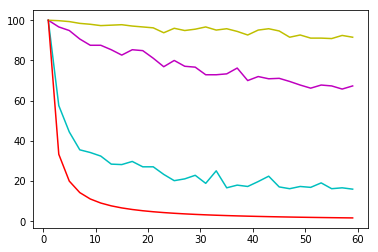

In [6]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()

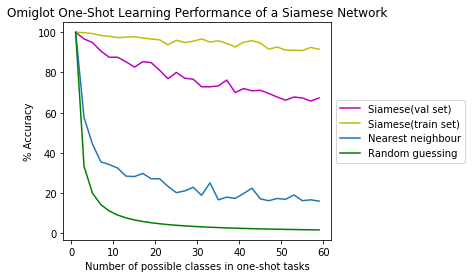

(20, 105, 105, 1)


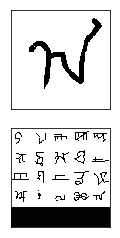

[[  1.41782002e-05]
 [  1.10376514e-01]
 [  3.61962593e-05]
 [  3.55265778e-03]
 [  1.82791890e-04]
 [  3.14894860e-04]
 [  6.53929362e-07]
 [  7.95615930e-03]
 [  7.53046712e-04]
 [  1.06953387e-03]
 [  6.35343677e-05]
 [  1.40683656e-03]
 [  4.60100864e-06]
 [  7.36018251e-07]
 [  9.71361175e-02]
 [  7.05882460e-02]
 [  5.24300558e-05]
 [  1.78120118e-02]
 [  1.13691494e-03]
 [  7.08678544e-01]]


In [7]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")
plt.plot(ways,nn_accs,label="Nearest neighbour")

ax.plot(ways,100.0/ways,"g",label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)

In [8]:

a=test_nn_accuracy(3,500,loader)
print(a)

Evaluating nearest neighbour on 500 unique 3 way one-shot learning tasks ...
57.8
